In [5]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
# from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
# from src.utils.utils import EarlyStopping, gmkdir
# from src.optim.optimizer import STLR
# from src.utils.utils import gaussian
from tqdm import *

In [6]:
device = torch.device("cuda:0")

In [7]:
class SynthDataset(Dataset):
    def __init__(self, opt):
        super(SynthDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
       	transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,))
                            ]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        if self.transform is not None:
            img = self.transform(img)
#             img = TF.autocontrast(img)
        item = {'img': img, 'idx':index}
        item['label'] = imagefile.split('_')[0]
        return item
    
class SynthCollator(object):
    
    def __call__(self, batch):
        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], 
                           max(width)], dtype=torch.float32).to(device)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)
        item = {'img': imgs, 'idx':indexes}
        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels
        return item

In [8]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
#         ks = [3, 3, 3, 3, 3, 3, 1]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [9]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [10]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

In [11]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
#             self.model = self.model
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

In [12]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'only_good_wo_contrast',
    'path':'./data',
    'imgdir': 'train',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':1200,
    'batch_size':128,
    'save_dir':'./checkpoints/',
    'log_dir':'./logs',
    'resume':True,
    'cuda':True,
    'schedule':False
    
}

data = SynthDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.9*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet


FileNotFoundError: [Errno 2] No such file or directory: './data/train'

In [ ]:
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
# gmkdir(savepath)
# gmkdir(args['log_dir'])
# optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
# learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
# learner.fit(args)

Let's use 2 GPUs!
checkpoint does not exist
None
Scheduling is False


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=3.72, val_ca=0, val_wa=0]


3.7185263633728027
Validation loss decreased (inf --> 3.718526).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=3.39, val_ca=0, val_wa=0]


3.553903102874756
Validation loss decreased (3.718526 --> 3.553903).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=3.28, val_ca=0, val_wa=0]


3.4631349245707193
Validation loss decreased (3.553903 --> 3.463135).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, val_loss=3.18, val_ca=0, val_wa=0]


3.392176628112793
Validation loss decreased (3.463135 --> 3.392177).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=3.25, val_ca=12.3, val_wa=0]


3.3642655849456786
Validation loss decreased (3.392177 --> 3.364266).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=3.17, val_ca=12.3, val_wa=0]


3.3311362266540527
Validation loss decreased (3.364266 --> 3.331136).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=2.97, val_ca=12.3, val_wa=0]


3.2790446622031078
Validation loss decreased (3.331136 --> 3.279045).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=3.25, val_ca=10.7, val_wa=0]


3.275797665119171
Validation loss decreased (3.279045 --> 3.275798).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=2.93, val_ca=19.8, val_wa=0]


3.237477011150784
Validation loss decreased (3.275798 --> 3.237477).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=4.31, val_ca=22.7, val_wa=0]


3.3442399740219115
EarlyStopping counter: (-3.237477 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=2.91, val_ca=18.9, val_wa=0]


3.3046299544247715
EarlyStopping counter: (-3.237477 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=2.79, val_ca=22.5, val_wa=0]


3.2620654702186584
EarlyStopping counter: (-3.237477 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=3.44, val_ca=0.166, val_wa=0]


3.2755481279813328
EarlyStopping counter: (-3.237477 4 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=2.81, val_ca=22.7, val_wa=0]


3.24252074105399
EarlyStopping counter: (-3.237477 5 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=2.74, val_ca=23.6, val_wa=0]


3.209024413426717
Validation loss decreased (3.237477 --> 3.209024).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=4.1, val_ca=2.75, val_wa=0]


3.264751300215721
EarlyStopping counter: (-3.209024 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=3.31, val_ca=9.36, val_wa=0]


3.2674081325531006
EarlyStopping counter: (-3.209024 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=2.87, val_ca=17.6, val_wa=0]


3.2453475528293185
EarlyStopping counter: (-3.209024 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=2.59, val_ca=23.8, val_wa=0]


3.210754733336599
EarlyStopping counter: (-3.209024 4 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=2.6, val_ca=23.6, val_wa=0]


3.180412268638611
Validation loss decreased (3.209024 --> 3.180412).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=2.7, val_ca=20.7, val_wa=0]


3.1575115408216203
Validation loss decreased (3.180412 --> 3.157512).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=5.01, val_ca=3.59, val_wa=0]


3.2415631359273736
EarlyStopping counter: (-3.157512 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=2.55, val_ca=23.2, val_wa=0]


3.2114869718966275
EarlyStopping counter: (-3.157512 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=2.63, val_ca=24.6, val_wa=0]


3.187089115381241
EarlyStopping counter: (-3.157512 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=2.99, val_ca=13.8, val_wa=0]


3.1793731307983397
EarlyStopping counter: (-3.157512 4 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=2.51, val_ca=23.4, val_wa=0]


3.1535306802162757
Validation loss decreased (3.157512 --> 3.153531).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=3.3, val_ca=23.8, val_wa=0]


3.159018322273537
EarlyStopping counter: (-3.153531 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=3.84, val_ca=12.4, val_wa=0]


3.1832094958850314
EarlyStopping counter: (-3.153531 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=3.85, val_ca=22.1, val_wa=0]


3.206243498571988
EarlyStopping counter: (-3.153531 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=2.51, val_ca=21.7, val_wa=0]


3.1829511086146036
EarlyStopping counter: (-3.153531 4 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=3.34, val_ca=24.9, val_wa=0]


3.1881748091789985
EarlyStopping counter: (-3.153531 5 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=4.68, val_ca=14.1, val_wa=0]


3.234807036817074
EarlyStopping counter: (-3.153531 6 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=2.24, val_ca=31.3, val_wa=0]


3.204590161641439
EarlyStopping counter: (-3.153531 7 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=3.97, val_ca=14.6, val_wa=0]


3.2272340480019066
EarlyStopping counter: (-3.153531 8 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=2.55, val_ca=23.1, val_wa=0]


3.207881648199899
EarlyStopping counter: (-3.153531 9 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=2.37, val_ca=32.8, val_wa=0]


3.1845077408684626
EarlyStopping counter: (-3.153531 10 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=1.87, val_ca=41.6, val_wa=0]


3.1490657683965324
Validation loss decreased (3.153531 --> 3.149066).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=1.75, val_ca=45.8, val_wa=0]


3.1122359915783533
Validation loss decreased (3.149066 --> 3.112236).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=1.93, val_ca=45.6, val_wa=0]


3.0818513356722317
Validation loss decreased (3.112236 --> 3.081851).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=1.77, val_ca=50.2, val_wa=0.0116]


3.0489576309919357
Validation loss decreased (3.081851 --> 3.048958).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=4.84, val_ca=27.1, val_wa=0]


3.0927428007125854
EarlyStopping counter: (-3.048958 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, val_loss=1.62, val_ca=50.8, val_wa=0]


3.057679454485575
EarlyStopping counter: (-3.048958 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=1.02, val_ca=69.4, val_wa=0.0698]


3.0104021527046383
Validation loss decreased (3.048958 --> 3.010402).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=1.79, val_ca=54, val_wa=0]


2.9825684509494086
Validation loss decreased (3.010402 --> 2.982568).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=1.65, val_ca=57.7, val_wa=0.0116]


2.9529975758658513
Validation loss decreased (2.982568 --> 2.952998).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s, val_loss=1.4, val_ca=59.7, val_wa=0.0233]


2.919217317000679
Validation loss decreased (2.952998 --> 2.919217).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=1.17, val_ca=68.7, val_wa=0.0465]


2.8819029331207275
Validation loss decreased (2.919217 --> 2.881903).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, val_loss=1.06, val_ca=72.9, val_wa=0.093]


2.8440265903870263
Validation loss decreased (2.881903 --> 2.844027).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.599, val_ca=85.2, val_wa=0.337]


2.7982193705986957
Validation loss decreased (2.844027 --> 2.798219).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=2.16, val_ca=48.6, val_wa=0.0116]


2.7854576408863068
Validation loss decreased (2.798219 --> 2.785458).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s, val_loss=2.44, val_ca=56.7, val_wa=0.0116]


2.77858732845269
Validation loss decreased (2.785458 --> 2.778587).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=1.88, val_ca=54.6, val_wa=0]


2.761292135486236
Validation loss decreased (2.778587 --> 2.761292).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.688, val_ca=82.5, val_wa=0.349]


2.722168700874976
Validation loss decreased (2.761292 --> 2.722169).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=1.18, val_ca=69.8, val_wa=0.14]


2.6936805193071014
Validation loss decreased (2.722169 --> 2.693681).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, val_loss=1.15, val_ca=69.8, val_wa=0.116]


2.665551975640384
Validation loss decreased (2.693681 --> 2.665552).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.507, val_ca=87.6, val_wa=0.535]


2.6270092725753784
Validation loss decreased (2.665552 --> 2.627009).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.612, val_ca=84.1, val_wa=0.384]


2.591658526345303
Validation loss decreased (2.627009 --> 2.591659).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=1.09, val_ca=75.7, val_wa=0.244]


2.5657734798974006
Validation loss decreased (2.591659 --> 2.565773).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.631, val_ca=85.1, val_wa=0.372]


2.532983761722759
Validation loss decreased (2.565773 --> 2.532984).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=1.97, val_ca=52.5, val_wa=0]


2.5236010293165845
Validation loss decreased (2.532984 --> 2.523601).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.696, val_ca=82.3, val_wa=0.395]


2.493645701252046
Validation loss decreased (2.523601 --> 2.493646).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.738, val_ca=83.2, val_wa=0.384]


2.4653274416923523
Validation loss decreased (2.493646 --> 2.465327).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.57, val_ca=84.7, val_wa=0.384]


2.4352504544787936
Validation loss decreased (2.465327 --> 2.435250).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=1.26, val_ca=71.3, val_wa=0.116]


2.416874933987856
Validation loss decreased (2.435250 --> 2.416875).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=1.55, val_ca=66.8, val_wa=0.0581]


2.4034803555561948
Validation loss decreased (2.416875 --> 2.403480).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.699, val_ca=83.4, val_wa=0.384]


2.377658541455413
Validation loss decreased (2.403480 --> 2.377659).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.488, val_ca=89.1, val_wa=0.57]


2.349458414227215
Validation loss decreased (2.377659 --> 2.349458).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.783, val_ca=82.3, val_wa=0.337]


2.3264230568619335
Validation loss decreased (2.349458 --> 2.326423).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.57, val_ca=85.1, val_wa=0.407]


2.3009724565174268
Validation loss decreased (2.326423 --> 2.300972).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=1.21, val_ca=70.7, val_wa=0.151]


2.285368290969304
Validation loss decreased (2.300972 --> 2.285368).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.755, val_ca=83.8, val_wa=0.302]


2.2638115253247006
Validation loss decreased (2.285368 --> 2.263812).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.755, val_ca=82, val_wa=0.349]


2.242856428027153
Validation loss decreased (2.263812 --> 2.242856).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.557, val_ca=88.7, val_wa=0.5]


2.219768359236521
Validation loss decreased (2.242856 --> 2.219768).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=1.01, val_ca=76.3, val_wa=0.221]


2.203482395893819
Validation loss decreased (2.219768 --> 2.203482).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.941, val_ca=77.2, val_wa=0.244]


2.1866492716471355
Validation loss decreased (2.203482 --> 2.186649).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.558, val_ca=88.3, val_wa=0.547]


2.165221128024553
Validation loss decreased (2.186649 --> 2.165221).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.446, val_ca=91, val_wa=0.605]


2.142890135963242
Validation loss decreased (2.165221 --> 2.142890).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.883, val_ca=80.6, val_wa=0.302]


2.12673575985126
Validation loss decreased (2.142890 --> 2.126736).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=2.86, val_ca=47.4, val_wa=0.0116]


2.1359836564788335
EarlyStopping counter: (-2.126736 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.851, val_ca=80.5, val_wa=0.337]


2.119924924522638
Validation loss decreased (2.126736 --> 2.119925).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.459, val_ca=90.3, val_wa=0.581]


2.099421940467976
Validation loss decreased (2.119925 --> 2.099422).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.569, val_ca=87.3, val_wa=0.523]


2.080760148240299
Validation loss decreased (2.099422 --> 2.080760).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=1.24, val_ca=76.8, val_wa=0.221]


2.0706570112561606
Validation loss decreased (2.080760 --> 2.070657).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.789, val_ca=84.9, val_wa=0.419]


2.055395479003588
Validation loss decreased (2.070657 --> 2.055395).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, val_loss=0.518, val_ca=89.2, val_wa=0.57]


2.037309364010306
Validation loss decreased (2.055395 --> 2.037309).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.389, val_ca=90.6, val_wa=0.64]


2.0181413940912067
Validation loss decreased (2.037309 --> 2.018141).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=1.21, val_ca=79.6, val_wa=0.267]


2.0088948802701356
Validation loss decreased (2.018141 --> 2.008895).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.543, val_ca=87.4, val_wa=0.465]


1.9922330430285498
Validation loss decreased (2.008895 --> 1.992233).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.434, val_ca=89.8, val_wa=0.547]


1.9747205503870933
Validation loss decreased (1.992233 --> 1.974721).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.525, val_ca=89.6, val_wa=0.581]


1.958608748515447
Validation loss decreased (1.974721 --> 1.958609).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.48, val_ca=89.9, val_wa=0.581]


1.9423648829643543
Validation loss decreased (1.958609 --> 1.942365).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.402, val_ca=92.8, val_wa=0.733]


1.9256271762044535
Validation loss decreased (1.942365 --> 1.925627).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, val_loss=0.564, val_ca=87.3, val_wa=0.5]


1.9109844818551054
Validation loss decreased (1.925627 --> 1.910984).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.439, val_ca=90.1, val_wa=0.628]


1.8953288590654414
Validation loss decreased (1.910984 --> 1.895329).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, val_loss=0.43, val_ca=90.7, val_wa=0.616]


1.8799032515601108
Validation loss decreased (1.895329 --> 1.879903).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.753, val_ca=82.3, val_wa=0.326]


1.8681685194994013
Validation loss decreased (1.879903 --> 1.868169).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=1.02, val_ca=80.3, val_wa=0.233]


1.8594018187105041
Validation loss decreased (1.868169 --> 1.859402).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.449, val_ca=91.4, val_wa=0.616]


1.845013083547962
Validation loss decreased (1.859402 --> 1.845013).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.523, val_ca=90, val_wa=0.616]


1.8316584702091987
Validation loss decreased (1.845013 --> 1.831658).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=1.29, val_ca=75.7, val_wa=0.302]


1.8262586745619773
Validation loss decreased (1.831658 --> 1.826259).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=1.3, val_ca=75.9, val_wa=0.256]


1.8210219826438638
Validation loss decreased (1.826259 --> 1.821022).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.523, val_ca=90.3, val_wa=0.616]


1.8082982380600536
Validation loss decreased (1.821022 --> 1.808298).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, val_loss=0.376, val_ca=91.9, val_wa=0.663]


1.794394341487329
Validation loss decreased (1.808298 --> 1.794394).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.532, val_ca=91.4, val_wa=0.605]


1.782257463496465
Validation loss decreased (1.794394 --> 1.782257).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.523, val_ca=89.7, val_wa=0.535]


1.7702663989294143
Validation loss decreased (1.782257 --> 1.770266).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=1.04, val_ca=80.6, val_wa=0.291]


1.7633832175776643
Validation loss decreased (1.770266 --> 1.763383).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.405, val_ca=92.2, val_wa=0.698]


1.7506896171057336
Validation loss decreased (1.763383 --> 1.750690).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.459, val_ca=92.6, val_wa=0.651]


1.7387257979975805
Validation loss decreased (1.750690 --> 1.738726).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.673, val_ca=87.5, val_wa=0.523]


1.7289499312365821
Validation loss decreased (1.738726 --> 1.728950).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, val_loss=0.894, val_ca=81.8, val_wa=0.302]


1.7213612751527265
Validation loss decreased (1.728950 --> 1.721361).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.574, val_ca=89.5, val_wa=0.605]


1.7110273027205252
Validation loss decreased (1.721361 --> 1.711027).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.401, val_ca=92.4, val_wa=0.674]


1.6993331887892313
Validation loss decreased (1.711027 --> 1.699333).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.351, val_ca=92.9, val_wa=0.733]


1.6873973325817986
Validation loss decreased (1.699333 --> 1.687397).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.415, val_ca=92.4, val_wa=0.686]


1.676235237142496
Validation loss decreased (1.687397 --> 1.676235).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.411, val_ca=93.5, val_wa=0.733]


1.6652296125888824
Validation loss decreased (1.676235 --> 1.665230).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.429, val_ca=92.5, val_wa=0.663]


1.6545756078999618
Validation loss decreased (1.665230 --> 1.654576).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.551, val_ca=91, val_wa=0.663]


1.645141244953514
Validation loss decreased (1.654576 --> 1.645141).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.572, val_ca=89.9, val_wa=0.57]


1.6360500111418255
Validation loss decreased (1.645141 --> 1.636050).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.797, val_ca=86, val_wa=0.419]


1.6289985099760425
Validation loss decreased (1.636050 --> 1.628999).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.531, val_ca=90.8, val_wa=0.628]


1.6198458403348923
Validation loss decreased (1.628999 --> 1.619846).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.485, val_ca=92.2, val_wa=0.64]


1.6104634914023817
Validation loss decreased (1.619846 --> 1.610463).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.442, val_ca=90.5, val_wa=0.628]


1.6008837118012007
Validation loss decreased (1.610463 --> 1.600884).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.442, val_ca=92.3, val_wa=0.674]


1.5914636157392485
Validation loss decreased (1.600884 --> 1.591464).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.753, val_ca=85.4, val_wa=0.43]


1.5847049826575863
Validation loss decreased (1.591464 --> 1.584705).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.633, val_ca=90, val_wa=0.57]


1.5770917162895202
Validation loss decreased (1.584705 --> 1.577092).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.405, val_ca=92, val_wa=0.674]


1.5677920196737563
Validation loss decreased (1.577092 --> 1.567792).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.462, val_ca=92.8, val_wa=0.698]


1.5590841167085752
Validation loss decreased (1.567792 --> 1.559084).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, val_loss=0.444, val_ca=92.4, val_wa=0.663]


1.5503760010469705
Validation loss decreased (1.559084 --> 1.550376).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=1.54, val_ca=75.5, val_wa=0.267]


1.5502702757831692
Validation loss decreased (1.550376 --> 1.550270).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s, val_loss=0.468, val_ca=91.2, val_wa=0.616]


1.5419427676842763
Validation loss decreased (1.550270 --> 1.541943).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.406, val_ca=92.4, val_wa=0.686]


1.5332719883845962
Validation loss decreased (1.541943 --> 1.533272).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.425, val_ca=91.7, val_wa=0.616]


1.524875248697671
Validation loss decreased (1.533272 --> 1.524875).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.54, val_ca=90.7, val_wa=0.57]


1.5174698719852848
Validation loss decreased (1.524875 --> 1.517470).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.418, val_ca=92.4, val_wa=0.651]


1.5092624490385624
Validation loss decreased (1.517470 --> 1.509262).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.627, val_ca=89, val_wa=0.581]


1.5027297808064355
Validation loss decreased (1.509262 --> 1.502730).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, val_loss=0.48, val_ca=91.4, val_wa=0.674]


1.4952118892003508
Validation loss decreased (1.502730 --> 1.495212).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.384, val_ca=93.6, val_wa=0.721]


1.4871044406925675
Validation loss decreased (1.495212 --> 1.487104).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.468, val_ca=91, val_wa=0.663]


1.4797165033178052
Validation loss decreased (1.487104 --> 1.479717).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.454, val_ca=92, val_wa=0.663]


1.4723406326856545
Validation loss decreased (1.479717 --> 1.472341).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.435, val_ca=93, val_wa=0.709]


1.4649275867002352
Validation loss decreased (1.472341 --> 1.464928).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.506, val_ca=91.1, val_wa=0.628]


1.458128478298796
Validation loss decreased (1.464928 --> 1.458128).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.501, val_ca=91.7, val_wa=0.663]


1.4513883760697406
Validation loss decreased (1.458128 --> 1.451388).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.355, val_ca=94, val_wa=0.733]


1.4437236219019323
Validation loss decreased (1.451388 --> 1.443724).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=0.418, val_ca=92.5, val_wa=0.674]


1.4366010692384508
Validation loss decreased (1.443724 --> 1.436601).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.661, val_ca=89.1, val_wa=0.547]


1.431253316895715
Validation loss decreased (1.436601 --> 1.431253).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.439, val_ca=92.8, val_wa=0.698]


1.4244547874143678
Validation loss decreased (1.431253 --> 1.424455).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.433, val_ca=93, val_wa=0.698]


1.4177102416145557
Validation loss decreased (1.424455 --> 1.417710).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.434, val_ca=93.1, val_wa=0.733]


1.4110627746259845
Validation loss decreased (1.417710 --> 1.411063).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.501, val_ca=93, val_wa=0.698]


1.4049521564637255
Validation loss decreased (1.411063 --> 1.404952).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.397, val_ca=93.4, val_wa=0.709]


1.3982345364491144
Validation loss decreased (1.404952 --> 1.398235).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.705, val_ca=89.1, val_wa=0.523]


1.3936432617784336
Validation loss decreased (1.398235 --> 1.393643).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.454, val_ca=92, val_wa=0.698]


1.3874634621958983
Validation loss decreased (1.393643 --> 1.387463).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.444, val_ca=92.3, val_wa=0.686]


1.381294215621512
Validation loss decreased (1.387463 --> 1.381294).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.405, val_ca=92.9, val_wa=0.686]


1.3749555300969583
Validation loss decreased (1.381294 --> 1.374956).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.479, val_ca=90.8, val_wa=0.593]


1.369175773474478
Validation loss decreased (1.374956 --> 1.369176).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.458, val_ca=92.7, val_wa=0.721]


1.3633358650482619
Validation loss decreased (1.369176 --> 1.363336).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.371, val_ca=93.9, val_wa=0.756]


1.3570146186716239
Validation loss decreased (1.363336 --> 1.357015).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.631, val_ca=89.3, val_wa=0.57]


1.352420892707909
Validation loss decreased (1.357015 --> 1.352421).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=0.465, val_ca=92.4, val_wa=0.651]


1.3468412942481491
Validation loss decreased (1.352421 --> 1.346841).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.348, val_ca=94.5, val_wa=0.744]


1.3405960362404585
Validation loss decreased (1.346841 --> 1.340596).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.335, val_ca=93.7, val_wa=0.756]


1.3343479170562318
Validation loss decreased (1.340596 --> 1.334348).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.414, val_ca=93.9, val_wa=0.733]


1.3286645885234998
Validation loss decreased (1.334348 --> 1.328665).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.454, val_ca=93, val_wa=0.721]


1.3232956333028758
Validation loss decreased (1.328665 --> 1.323296).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.622, val_ca=91, val_wa=0.651]


1.3190178018881054
Validation loss decreased (1.323296 --> 1.319018).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.925, val_ca=83.8, val_wa=0.407]


1.3166275669227947
Validation loss decreased (1.319018 --> 1.316628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.463, val_ca=92.4, val_wa=0.64]


1.3114867018288876
Validation loss decreased (1.316628 --> 1.311487).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.429, val_ca=94, val_wa=0.814]


1.3062018432660016
Validation loss decreased (1.311487 --> 1.306202).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.45, val_ca=92.7, val_wa=0.721]


1.3011056376355035
Validation loss decreased (1.306202 --> 1.301106).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.406, val_ca=93.8, val_wa=0.756]


1.295810722387754
Validation loss decreased (1.301106 --> 1.295811).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.513, val_ca=93, val_wa=0.744]


1.2912065825041603
Validation loss decreased (1.295811 --> 1.291207).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.461, val_ca=94.1, val_wa=0.779]


1.2863530417283375
Validation loss decreased (1.291207 --> 1.286353).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.432, val_ca=93.8, val_wa=0.721]


1.281388134284075
Validation loss decreased (1.286353 --> 1.281388).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.369, val_ca=94.5, val_wa=0.779]


1.2761140159099778
Validation loss decreased (1.281388 --> 1.276114).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.424, val_ca=94.1, val_wa=0.779]


1.2712142135220013
Validation loss decreased (1.276114 --> 1.271214).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.437, val_ca=93.3, val_wa=0.733]


1.266446329695838
Validation loss decreased (1.271214 --> 1.266446).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.497, val_ca=93.2, val_wa=0.733]


1.2620721369643102
Validation loss decreased (1.266446 --> 1.262072).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.384, val_ca=94.3, val_wa=0.814]


1.2571113355415688
Validation loss decreased (1.262072 --> 1.257111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.499, val_ca=92.6, val_wa=0.686]


1.2528495189179196
Validation loss decreased (1.257111 --> 1.252850).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.456, val_ca=92.2, val_wa=0.686]


1.2483988857136092
Validation loss decreased (1.252850 --> 1.248399).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.504, val_ca=92.8, val_wa=0.733]


1.244265123208364
Validation loss decreased (1.248399 --> 1.244265).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s, val_loss=0.421, val_ca=93.6, val_wa=0.744]


1.2397178134865523
Validation loss decreased (1.244265 --> 1.239718).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.447, val_ca=93, val_wa=0.733]


1.235362592798013
Validation loss decreased (1.239718 --> 1.235363).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.516, val_ca=92.1, val_wa=0.651]


1.2314328432408839
Validation loss decreased (1.235363 --> 1.231433).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, val_loss=0.552, val_ca=90.2, val_wa=0.547]


1.2277402863230393
Validation loss decreased (1.231433 --> 1.227740).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.447, val_ca=92.9, val_wa=0.686]


1.2235201906513524
Validation loss decreased (1.227740 --> 1.223520).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.65, val_ca=88.5, val_wa=0.453]


1.2204385880501039
Validation loss decreased (1.223520 --> 1.220439).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.413, val_ca=92.6, val_wa=0.698]


1.21612108725915
Validation loss decreased (1.220439 --> 1.216121).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.464, val_ca=92.5, val_wa=0.767]


1.2121208008933575
Validation loss decreased (1.216121 --> 1.212121).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.388, val_ca=93.3, val_wa=0.709]


1.2077601826380169
Validation loss decreased (1.212121 --> 1.207760).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.498, val_ca=92.5, val_wa=0.709]


1.2040243860922362
Validation loss decreased (1.207760 --> 1.204024).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, val_loss=0.381, val_ca=94, val_wa=0.733]


1.1997156996689542
Validation loss decreased (1.204024 --> 1.199716).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.384, val_ca=93.9, val_wa=0.709]


1.1954677297423284
Validation loss decreased (1.199716 --> 1.195468).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.51, val_ca=91.9, val_wa=0.686]


1.1919173465491577
Validation loss decreased (1.195468 --> 1.191917).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.465, val_ca=93.2, val_wa=0.733]


1.1881680061522217
Validation loss decreased (1.191917 --> 1.188168).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.514, val_ca=91.1, val_wa=0.663]


1.1847115681721614
Validation loss decreased (1.188168 --> 1.184712).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.543, val_ca=93, val_wa=0.733]


1.1814362370238012
Validation loss decreased (1.184712 --> 1.181436).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.471, val_ca=92.8, val_wa=0.733]


1.1778312750576716
Validation loss decreased (1.181436 --> 1.177831).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.616, val_ca=91.6, val_wa=0.709]


1.1749952668794479
Validation loss decreased (1.177831 --> 1.174995).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, val_loss=0.506, val_ca=91.2, val_wa=0.663]


1.1716353634194514
Validation loss decreased (1.174995 --> 1.171635).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.442, val_ca=92.3, val_wa=0.733]


1.1679865702986718
Validation loss decreased (1.171635 --> 1.167987).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.718, val_ca=89.7, val_wa=0.547]


1.1657479443953405
Validation loss decreased (1.167987 --> 1.165748).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.532, val_ca=93.4, val_wa=0.674]


1.162611593999485
Validation loss decreased (1.165748 --> 1.162612).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.347, val_ca=95.7, val_wa=0.802]


1.1585937568119593
Validation loss decreased (1.162612 --> 1.158594).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.36, val_ca=93.9, val_wa=0.709]


1.1546796301708502
Validation loss decreased (1.158594 --> 1.154680).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.455, val_ca=93.1, val_wa=0.674]


1.1512674565722303
Validation loss decreased (1.154680 --> 1.151267).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s, val_loss=0.431, val_ca=94.2, val_wa=0.733]


1.1477708984347224
Validation loss decreased (1.151267 --> 1.147771).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.552, val_ca=91.9, val_wa=0.651]


1.1448938184314303
Validation loss decreased (1.147771 --> 1.144894).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.45, val_ca=93.4, val_wa=0.756]


1.1415512934327126
Validation loss decreased (1.144894 --> 1.141551).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.519, val_ca=92.2, val_wa=0.674]


1.1385704641136827
Validation loss decreased (1.141551 --> 1.138570).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.57, val_ca=93.2, val_wa=0.686]


1.135864494811921
Validation loss decreased (1.138570 --> 1.135864).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.491, val_ca=92.5, val_wa=0.721]


1.1328082869968144
Validation loss decreased (1.135864 --> 1.132808).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.804, val_ca=87, val_wa=0.477]


1.1312588652912177
Validation loss decreased (1.132808 --> 1.131259).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.516, val_ca=92.6, val_wa=0.674]


1.128370400605627
Validation loss decreased (1.131259 --> 1.128370).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.44, val_ca=93.4, val_wa=0.721]


1.125155321069967
Validation loss decreased (1.128370 --> 1.125155).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.423, val_ca=94.5, val_wa=0.756]


1.1218895980091983
Validation loss decreased (1.125155 --> 1.121890).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.523, val_ca=91.1, val_wa=0.64]


1.1191174916371152
Validation loss decreased (1.121890 --> 1.119117).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.465, val_ca=92.2, val_wa=0.628]


1.1161052163020806
Validation loss decreased (1.119117 --> 1.116105).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.376, val_ca=95.2, val_wa=0.802]


1.112711251875676
Validation loss decreased (1.116105 --> 1.112711).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.438, val_ca=93.5, val_wa=0.674]


1.1096305014335945
Validation loss decreased (1.112711 --> 1.109631).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.365, val_ca=95.5, val_wa=0.802]


1.106245675005696
Validation loss decreased (1.109631 --> 1.106246).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.514, val_ca=92.6, val_wa=0.628]


1.103564391983041
Validation loss decreased (1.106246 --> 1.103564).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.404, val_ca=94.3, val_wa=0.767]


1.1004152738296233
Validation loss decreased (1.103564 --> 1.100415).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.341, val_ca=95.3, val_wa=0.791]


1.0970114045880834
Validation loss decreased (1.100415 --> 1.097011).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.346, val_ca=95.8, val_wa=0.802]


1.0936599341886384
Validation loss decreased (1.097011 --> 1.093660).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.486, val_ca=92.8, val_wa=0.709]


1.090957554578781
Validation loss decreased (1.093660 --> 1.090958).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.514, val_ca=93, val_wa=0.674]


1.0884026656899832
Validation loss decreased (1.090958 --> 1.088403).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, val_loss=0.496, val_ca=93.2, val_wa=0.674]


1.085793419425183
Validation loss decreased (1.088403 --> 1.085793).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.434, val_ca=93.7, val_wa=0.721]


1.0829367705604487
Validation loss decreased (1.085793 --> 1.082937).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.403, val_ca=93.3, val_wa=0.756]


1.079965834143901
Validation loss decreased (1.082937 --> 1.079966).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.401, val_ca=93.8, val_wa=0.733]


1.0770144693229509
Validation loss decreased (1.079966 --> 1.077014).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=0.549, val_ca=91.8, val_wa=0.628]


1.0747278771359168
Validation loss decreased (1.077014 --> 1.074728).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.501, val_ca=92.2, val_wa=0.651]


1.0722562883948457
Validation loss decreased (1.074728 --> 1.072256).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.494, val_ca=91.8, val_wa=0.616]


1.069774796906459
Validation loss decreased (1.072256 --> 1.069775).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.448, val_ca=92.9, val_wa=0.674]


1.0671168899434245
Validation loss decreased (1.069775 --> 1.067117).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, val_loss=0.374, val_ca=94.5, val_wa=0.733]


1.0641680234290183
Validation loss decreased (1.067117 --> 1.064168).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.386, val_ca=94.7, val_wa=0.709]


1.0612929262599702
Validation loss decreased (1.064168 --> 1.061293).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.536, val_ca=90.2, val_wa=0.57]


1.0590784744622839
Validation loss decreased (1.061293 --> 1.059078).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.417, val_ca=93.9, val_wa=0.663]


1.0563824513629705
Validation loss decreased (1.059078 --> 1.056382).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, val_loss=0.354, val_ca=95.2, val_wa=0.756]


1.0534454984395574
Validation loss decreased (1.056382 --> 1.053445).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.418, val_ca=93.9, val_wa=0.721]


1.0507983314494291
Validation loss decreased (1.053445 --> 1.050798).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.352, val_ca=95, val_wa=0.756]


1.0478982632338258
Validation loss decreased (1.050798 --> 1.047898).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.351, val_ca=94.8, val_wa=0.779]


1.045017864709058
Validation loss decreased (1.047898 --> 1.045018).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.609, val_ca=90, val_wa=0.581]


1.043222894761788
Validation loss decreased (1.045018 --> 1.043223).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.374, val_ca=95, val_wa=0.802]


1.040480549096084
Validation loss decreased (1.043223 --> 1.040481).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.402, val_ca=93.9, val_wa=0.709]


1.0378749949591501
Validation loss decreased (1.040481 --> 1.037875).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, val_loss=0.498, val_ca=92.5, val_wa=0.651]


1.0356800122474268
Validation loss decreased (1.037875 --> 1.035680).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.471, val_ca=93.1, val_wa=0.674]


1.0333957981001511
Validation loss decreased (1.035680 --> 1.033396).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.34, val_ca=95.9, val_wa=0.791]


1.0305985576443133
Validation loss decreased (1.033396 --> 1.030599).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, val_loss=0.463, val_ca=94.7, val_wa=0.744]


1.0283209081873836
Validation loss decreased (1.030599 --> 1.028321).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.348, val_ca=95.1, val_wa=0.802]


1.0255994474887848
Validation loss decreased (1.028321 --> 1.025599).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s, val_loss=0.375, val_ca=95, val_wa=0.779]


1.0230077806696949
Validation loss decreased (1.025599 --> 1.023008).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.46, val_ca=93.5, val_wa=0.721]


1.0207748886138674
Validation loss decreased (1.023008 --> 1.020775).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.475, val_ca=94.5, val_wa=0.709]


1.018617810232366
Validation loss decreased (1.020775 --> 1.018618).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=1.15, val_ca=84.9, val_wa=0.419]


1.0191455753300134
EarlyStopping counter: (-1.018618 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.405, val_ca=95.5, val_wa=0.779]


1.0167373854739994
Validation loss decreased (1.018618 --> 1.016737).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.356, val_ca=93.8, val_wa=0.721]


1.0141578168841079
Validation loss decreased (1.016737 --> 1.014158).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, val_loss=0.63, val_ca=91.5, val_wa=0.686]


1.0126637151964908
Validation loss decreased (1.014158 --> 1.012664).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.575, val_ca=92.1, val_wa=0.628]


1.0109681777020758
Validation loss decreased (1.012664 --> 1.010968).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.764, val_ca=88.7, val_wa=0.558]


1.0100164573395114
Validation loss decreased (1.010968 --> 1.010016).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.416, val_ca=95, val_wa=0.791]


1.0077309029606671
Validation loss decreased (1.010016 --> 1.007731).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.53, val_ca=92.7, val_wa=0.709]


1.0059014646714675
Validation loss decreased (1.007731 --> 1.005901).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.481, val_ca=93.7, val_wa=0.686]


1.0038988906463593
Validation loss decreased (1.005901 --> 1.003899).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.519, val_ca=91.9, val_wa=0.674]


1.0020543817331582
Validation loss decreased (1.003899 --> 1.002054).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=0.426, val_ca=94, val_wa=0.698]


0.9998709902618871
Validation loss decreased (1.002054 --> 0.999871).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.357, val_ca=94.5, val_wa=0.744]


0.9974451540776019
Validation loss decreased (0.999871 --> 0.997445).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.422, val_ca=92.9, val_wa=0.651]


0.9952800111438995
Validation loss decreased (0.997445 --> 0.995280).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.356, val_ca=94, val_wa=0.721]


0.9928860426618812
Validation loss decreased (0.995280 --> 0.992886).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.499, val_ca=93, val_wa=0.686]


0.9910431667717535
Validation loss decreased (0.992886 --> 0.991043).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.357, val_ca=94.8, val_wa=0.791]


0.9886847521735833
Validation loss decreased (0.991043 --> 0.988685).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.422, val_ca=94.2, val_wa=0.779]


0.9865856094492806
Validation loss decreased (0.988685 --> 0.986586).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, val_loss=0.346, val_ca=95.6, val_wa=0.791]


0.9842225609010437
Validation loss decreased (0.986586 --> 0.984223).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.386, val_ca=93.7, val_wa=0.674]


0.9820232815383112
Validation loss decreased (0.984223 --> 0.982023).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.566, val_ca=92.1, val_wa=0.686]


0.9804997993257892
Validation loss decreased (0.982023 --> 0.980500).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=0.342, val_ca=95, val_wa=0.779]


0.9781700024639604
Validation loss decreased (0.980500 --> 0.978170).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.412, val_ca=94.1, val_wa=0.709]


0.9761123932491649
Validation loss decreased (0.978170 --> 0.976112).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.444, val_ca=93.9, val_wa=0.721]


0.9741855155730593
Validation loss decreased (0.976112 --> 0.974186).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.421, val_ca=94, val_wa=0.756]


0.9721891141970666
Validation loss decreased (0.974186 --> 0.972189).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.393, val_ca=94, val_wa=0.709]


0.9701042783131703
Validation loss decreased (0.972189 --> 0.970104).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.481, val_ca=92.7, val_wa=0.721]


0.9683522385508356
Validation loss decreased (0.970104 --> 0.968352).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.368, val_ca=94.8, val_wa=0.791]


0.9662064494831222
Validation loss decreased (0.968352 --> 0.966206).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.478, val_ca=93.4, val_wa=0.709]


0.964468287191357
Validation loss decreased (0.966206 --> 0.964468).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.391, val_ca=95, val_wa=0.744]


0.9624359810605962
Validation loss decreased (0.964468 --> 0.962436).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.339, val_ca=95.5, val_wa=0.814]


0.9602331206360469
Validation loss decreased (0.962436 --> 0.960233).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.434, val_ca=94.4, val_wa=0.744]


0.958380536819008
Validation loss decreased (0.960233 --> 0.958381).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.422, val_ca=93.7, val_wa=0.721]


0.9564995587917796
Validation loss decreased (0.958381 --> 0.956500).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.389, val_ca=94, val_wa=0.767]


0.9545150599279604
Validation loss decreased (0.956500 --> 0.954515).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.341, val_ca=95.7, val_wa=0.802]


0.9523781487127629
Validation loss decreased (0.954515 --> 0.952378).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.312, val_ca=95.9, val_wa=0.814]


0.9501562476572063
Validation loss decreased (0.952378 --> 0.950156).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.337, val_ca=95, val_wa=0.767]


0.948034788498004
Validation loss decreased (0.950156 --> 0.948035).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s, val_loss=0.339, val_ca=95.3, val_wa=0.802]


0.9459330898934397
Validation loss decreased (0.948035 --> 0.945933).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.384, val_ca=94.7, val_wa=0.791]


0.9440026386701774
Validation loss decreased (0.945933 --> 0.944003).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s, val_loss=0.296, val_ca=95.8, val_wa=0.814]


0.9417839731051497
Validation loss decreased (0.944003 --> 0.941784).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=0.31, val_ca=95.8, val_wa=0.802]


0.939626541255684
Validation loss decreased (0.941784 --> 0.939627).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.36, val_ca=94.5, val_wa=0.721]


0.9376561723801554
Validation loss decreased (0.939627 --> 0.937656).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.362, val_ca=95.5, val_wa=0.779]


0.9357061620485985
Validation loss decreased (0.937656 --> 0.935706).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.451, val_ca=94.3, val_wa=0.756]


0.9340690402565776
Validation loss decreased (0.935706 --> 0.934069).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.372, val_ca=94.6, val_wa=0.791]


0.9321759096299759
Validation loss decreased (0.934069 --> 0.932176).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.426, val_ca=93.4, val_wa=0.756]


0.9304786754534549
Validation loss decreased (0.932176 --> 0.930479).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, val_loss=0.366, val_ca=95.3, val_wa=0.802]


0.9285895815461774
Validation loss decreased (0.930479 --> 0.928590).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.351, val_ca=93.8, val_wa=0.744]


0.9266634080807368
Validation loss decreased (0.928590 --> 0.926663).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.382, val_ca=95, val_wa=0.791]


0.9248549710476517
Validation loss decreased (0.926663 --> 0.924855).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.418, val_ca=95, val_wa=0.779]


0.9231767918889886
Validation loss decreased (0.924855 --> 0.923177).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.473, val_ca=94.2, val_wa=0.733]


0.9216910644923106
Validation loss decreased (0.923177 --> 0.921691).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.34, val_ca=95.6, val_wa=0.826]


0.919777803809235
Validation loss decreased (0.921691 --> 0.919778).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.345, val_ca=95, val_wa=0.779]


0.9178948832339928
Validation loss decreased (0.919778 --> 0.917895).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.35, val_ca=95.6, val_wa=0.791]


0.9160375213311389
Validation loss decreased (0.917895 --> 0.916038).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, val_loss=0.417, val_ca=94.6, val_wa=0.779]


0.9144130430703055
Validation loss decreased (0.916038 --> 0.914413).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.39, val_ca=93.5, val_wa=0.744]


0.9127111849072692
Validation loss decreased (0.914413 --> 0.912711).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s, val_loss=0.489, val_ca=94, val_wa=0.744]


0.9113414569194263
Validation loss decreased (0.912711 --> 0.911341).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.422, val_ca=94.3, val_wa=0.767]


0.9097638695470749
Validation loss decreased (0.911341 --> 0.909764).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.415, val_ca=94.7, val_wa=0.767]


0.9081745584678037
Validation loss decreased (0.909764 --> 0.908175).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.434, val_ca=95, val_wa=0.779]


0.906655624222297
Validation loss decreased (0.908175 --> 0.906656).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.435, val_ca=94.7, val_wa=0.791]


0.9051492662665943
Validation loss decreased (0.906656 --> 0.905149).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.481, val_ca=94.2, val_wa=0.779]


0.9037986112058543
Validation loss decreased (0.905149 --> 0.903799).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.455, val_ca=93.9, val_wa=0.779]


0.9023747192488776
Validation loss decreased (0.903799 --> 0.902375).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s, val_loss=0.449, val_ca=94.1, val_wa=0.721]


0.9009410076880757
Validation loss decreased (0.902375 --> 0.900941).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.449, val_ca=94.4, val_wa=0.756]


0.8995141614498776
Validation loss decreased (0.900941 --> 0.899514).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.391, val_ca=95.2, val_wa=0.802]


0.8979165989835307
Validation loss decreased (0.899514 --> 0.897917).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.35, val_ca=95.3, val_wa=0.767]


0.896198598101595
Validation loss decreased (0.897917 --> 0.896199).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.36, val_ca=94.4, val_wa=0.744]


0.8945228756405413
Validation loss decreased (0.896199 --> 0.894523).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.364, val_ca=94.7, val_wa=0.733]


0.8928713440152344
Validation loss decreased (0.894523 --> 0.892871).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.485, val_ca=92.7, val_wa=0.709]


0.8916032608621609
Validation loss decreased (0.892871 --> 0.891603).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.37, val_ca=94.9, val_wa=0.791]


0.8899888196043185
Validation loss decreased (0.891603 --> 0.889989).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.342, val_ca=95.8, val_wa=0.86]


0.8882972497814967
Validation loss decreased (0.889989 --> 0.888297).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.345, val_ca=95.8, val_wa=0.837]


0.8866240812264956
Validation loss decreased (0.888297 --> 0.886624).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.375, val_ca=95.7, val_wa=0.837]


0.8850532830492851
Validation loss decreased (0.886624 --> 0.885053).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.392, val_ca=94.7, val_wa=0.791]


0.8835460384139956
Validation loss decreased (0.885053 --> 0.883546).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.449, val_ca=94.7, val_wa=0.779]


0.8822219262762767
Validation loss decreased (0.883546 --> 0.882222).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.402, val_ca=94, val_wa=0.733]


0.8807616437640958
Validation loss decreased (0.882222 --> 0.880762).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.359, val_ca=94.5, val_wa=0.779]


0.8791791246695952
Validation loss decreased (0.880762 --> 0.879179).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.371, val_ca=94.9, val_wa=0.779]


0.8776427440772964
Validation loss decreased (0.879179 --> 0.877643).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.353, val_ca=96.2, val_wa=0.849]


0.8760635683155922
Validation loss decreased (0.877643 --> 0.876064).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.365, val_ca=95.7, val_wa=0.814]


0.8745280113127138
Validation loss decreased (0.876064 --> 0.874528).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.413, val_ca=94.8, val_wa=0.791]


0.8731461563510096
Validation loss decreased (0.874528 --> 0.873146).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.419, val_ca=95, val_wa=0.767]


0.8717917188779631
Validation loss decreased (0.873146 --> 0.871792).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.384, val_ca=95.4, val_wa=0.767]


0.8703392873562518
Validation loss decreased (0.871792 --> 0.870339).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.381, val_ca=95.7, val_wa=0.779]


0.868886721770912
Validation loss decreased (0.870339 --> 0.868887).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.384, val_ca=95.5, val_wa=0.779]


0.867451982208963
Validation loss decreased (0.868887 --> 0.867452).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s, val_loss=0.387, val_ca=95.4, val_wa=0.779]


0.8660359975159344
Validation loss decreased (0.867452 --> 0.866036).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s, val_loss=0.387, val_ca=95.4, val_wa=0.779]


0.8646278929184464
Validation loss decreased (0.866036 --> 0.864628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.373, val_ca=95.5, val_wa=0.791]


0.863184957210619
Validation loss decreased (0.864628 --> 0.863185).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.41, val_ca=95.2, val_wa=0.756]


0.8618594400192562
Validation loss decreased (0.863185 --> 0.861859).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.386, val_ca=95.2, val_wa=0.767]


0.8604730462367611
Validation loss decreased (0.861859 --> 0.860473).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.42, val_ca=95.2, val_wa=0.767]


0.8591934741409712
Validation loss decreased (0.860473 --> 0.859193).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.416, val_ca=95.2, val_wa=0.791]


0.8579094682050787
Validation loss decreased (0.859193 --> 0.857909).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.406, val_ca=95.4, val_wa=0.802]


0.8566044584519601
Validation loss decreased (0.857909 --> 0.856604).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.445, val_ca=95, val_wa=0.779]


0.855419293432483
Validation loss decreased (0.856604 --> 0.855419).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.419, val_ca=95.2, val_wa=0.779]


0.8541647911756888
Validation loss decreased (0.855419 --> 0.854165).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.392, val_ca=95.5, val_wa=0.814]


0.8528401444327183
Validation loss decreased (0.854165 --> 0.852840).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.393, val_ca=95.7, val_wa=0.837]


0.8515264305046627
Validation loss decreased (0.852840 --> 0.851526).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.392, val_ca=95.1, val_wa=0.826]


0.850217792722914
Validation loss decreased (0.851526 --> 0.850218).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.363, val_ca=95.8, val_wa=0.802]


0.8488325748423283
Validation loss decreased (0.850218 --> 0.848833).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.472, val_ca=94.5, val_wa=0.756]


0.8477663316740193
Validation loss decreased (0.848833 --> 0.847766).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.45, val_ca=95.8, val_wa=0.814]


0.8466437405112099
Validation loss decreased (0.847766 --> 0.846644).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.349, val_ca=96.3, val_wa=0.826]


0.845242842066456
Validation loss decreased (0.846644 --> 0.845243).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.554, val_ca=91.9, val_wa=0.628]


0.8444242242179559
Validation loss decreased (0.845243 --> 0.844424).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.451, val_ca=95, val_wa=0.791]


0.8433214692341513
Validation loss decreased (0.844424 --> 0.843321).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.41, val_ca=95.2, val_wa=0.802]


0.8421111439859401
Validation loss decreased (0.843321 --> 0.842111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.519, val_ca=92.9, val_wa=0.686]


0.8412118173907395
Validation loss decreased (0.842111 --> 0.841212).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=0.727, val_ca=89.7, val_wa=0.535]


0.8408935922715399
Validation loss decreased (0.841212 --> 0.840894).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.775, val_ca=89.8, val_wa=0.547]


0.8407122745408245
Validation loss decreased (0.840894 --> 0.840712).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.433, val_ca=93.9, val_wa=0.756]


0.8395869886677568
Validation loss decreased (0.840712 --> 0.839587).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.756, val_ca=89.5, val_wa=0.616]


0.8393562600303944
Validation loss decreased (0.839587 --> 0.839356).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.487, val_ca=93.7, val_wa=0.733]


0.838388011105113
Validation loss decreased (0.839356 --> 0.838388).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.441, val_ca=95, val_wa=0.814]


0.8372994044055677
Validation loss decreased (0.838388 --> 0.837299).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.428, val_ca=94.8, val_wa=0.779]


0.8361814770379353
Validation loss decreased (0.837299 --> 0.836181).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, val_loss=0.445, val_ca=92.1, val_wa=0.663]


0.8351169386903986
Validation loss decreased (0.836181 --> 0.835117).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.632, val_ca=91.1, val_wa=0.605]


0.8345645262009423
Validation loss decreased (0.835117 --> 0.834565).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.4, val_ca=94.3, val_wa=0.733]


0.8333878125440137
Validation loss decreased (0.834565 --> 0.833388).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.493, val_ca=94.1, val_wa=0.721]


0.8324667667214934
Validation loss decreased (0.833388 --> 0.832467).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.486, val_ca=93, val_wa=0.674]


0.8315336546004621
Validation loss decreased (0.832467 --> 0.831534).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.421, val_ca=94.8, val_wa=0.767]


0.8304292068526309
Validation loss decreased (0.831534 --> 0.830429).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.374, val_ca=95, val_wa=0.767]


0.8292060215575445
Validation loss decreased (0.830429 --> 0.829206).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.508, val_ca=91.9, val_wa=0.651]


0.828347858340345
Validation loss decreased (0.829206 --> 0.828348).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.421, val_ca=94, val_wa=0.733]


0.827262930393219
Validation loss decreased (0.828348 --> 0.827263).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.379, val_ca=94.5, val_wa=0.756]


0.8260710466098278
Validation loss decreased (0.827263 --> 0.826071).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.454, val_ca=93.2, val_wa=0.709]


0.8250849028797301
Validation loss decreased (0.826071 --> 0.825085).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.423, val_ca=95, val_wa=0.767]


0.8240211860685752
Validation loss decreased (0.825085 --> 0.824021).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.589, val_ca=92.7, val_wa=0.698]


0.8233998075795992
Validation loss decreased (0.824021 --> 0.823400).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.659, val_ca=91.3, val_wa=0.686]


0.822966430610732
Validation loss decreased (0.823400 --> 0.822966).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.715, val_ca=91.2, val_wa=0.605]


0.822682073657594
Validation loss decreased (0.822966 --> 0.822682).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.422, val_ca=93, val_wa=0.709]


0.8216331942855376
Validation loss decreased (0.822682 --> 0.821633).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.285, val_ca=95.5, val_wa=0.791]


0.8202317242678401
Validation loss decreased (0.821633 --> 0.820232).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.31, val_ca=95.4, val_wa=0.791]


0.8189037147288522
Validation loss decreased (0.820232 --> 0.818904).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.318, val_ca=96, val_wa=0.814]


0.8176030807680897
Validation loss decreased (0.818904 --> 0.817603).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, val_loss=0.371, val_ca=94.5, val_wa=0.733]


0.8164470164887028
Validation loss decreased (0.817603 --> 0.816447).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.356, val_ca=95.2, val_wa=0.756]


0.8152579698297713
Validation loss decreased (0.816447 --> 0.815258).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.337, val_ca=95.7, val_wa=0.791]


0.8140255502357925
Validation loss decreased (0.815258 --> 0.814026).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.331, val_ca=95.8, val_wa=0.802]


0.8127849590042869
Validation loss decreased (0.814026 --> 0.812785).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.308, val_ca=96.2, val_wa=0.814]


0.8114912346387521
Validation loss decreased (0.812785 --> 0.811491).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.367, val_ca=95.3, val_wa=0.779]


0.8103542998623665
Validation loss decreased (0.811491 --> 0.810354).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.434, val_ca=94, val_wa=0.733]


0.8093941581948679
Validation loss decreased (0.810354 --> 0.809394).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.426, val_ca=95.7, val_wa=0.802]


0.8084191067224847
Validation loss decreased (0.809394 --> 0.808419).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.47, val_ca=94.8, val_wa=0.756]


0.8075598159871126
Validation loss decreased (0.808419 --> 0.807560).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, val_loss=0.411, val_ca=95.8, val_wa=0.826]


0.8065561902673939
Validation loss decreased (0.807560 --> 0.806556).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s, val_loss=0.475, val_ca=95.7, val_wa=0.814]


0.8057179279399641
Validation loss decreased (0.806556 --> 0.805718).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.466, val_ca=95.3, val_wa=0.802]


0.8048625443534226
Validation loss decreased (0.805718 --> 0.804863).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.405, val_ca=94.3, val_wa=0.779]


0.8038585007789746
Validation loss decreased (0.804863 --> 0.803859).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.45, val_ca=94.5, val_wa=0.767]


0.8029728602795374
Validation loss decreased (0.803859 --> 0.802973).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.396, val_ca=94.7, val_wa=0.733]


0.8019553533941507
Validation loss decreased (0.802973 --> 0.801955).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.372, val_ca=94.7, val_wa=0.779]


0.8008841580137648
Validation loss decreased (0.801955 --> 0.800884).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.361, val_ca=95.6, val_wa=0.826]


0.7997907990246863
Validation loss decreased (0.800884 --> 0.799791).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.337, val_ca=96.5, val_wa=0.86]


0.7986425659053084
Validation loss decreased (0.799791 --> 0.798643).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, val_loss=0.318, val_ca=96.5, val_wa=0.849]


0.7974531129002571
Validation loss decreased (0.798643 --> 0.797453).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.378, val_ca=96.3, val_wa=0.837]


0.7964186520488173
Validation loss decreased (0.797453 --> 0.796419).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.357, val_ca=96.3, val_wa=0.837]


0.7953371988435097
Validation loss decreased (0.796419 --> 0.795337).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.361, val_ca=95.8, val_wa=0.826]


0.7942689927409263
Validation loss decreased (0.795337 --> 0.794269).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.41, val_ca=96.1, val_wa=0.802]


0.7933282049409315
Validation loss decreased (0.794269 --> 0.793328).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.374, val_ca=95.6, val_wa=0.814]


0.7923041716181561
Validation loss decreased (0.793328 --> 0.792304).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.412, val_ca=95.5, val_wa=0.802]


0.7913767974551131
Validation loss decreased (0.792304 --> 0.791377).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.488, val_ca=94.2, val_wa=0.802]


0.7906397707995997
Validation loss decreased (0.791377 --> 0.790640).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.375, val_ca=95.8, val_wa=0.837]


0.7896312342830074
Validation loss decreased (0.790640 --> 0.789631).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.413, val_ca=94.8, val_wa=0.802]


0.7887182285508578
Validation loss decreased (0.789631 --> 0.788718).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.364, val_ca=95.3, val_wa=0.814]


0.7876929347065912
Validation loss decreased (0.788718 --> 0.787693).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.437, val_ca=94.5, val_wa=0.767]


0.7868472044726452
Validation loss decreased (0.787693 --> 0.786847).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.414, val_ca=94.6, val_wa=0.779]


0.7859521139269838
Validation loss decreased (0.786847 --> 0.785952).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.324, val_ca=95.3, val_wa=0.791]


0.7848431228590812
Validation loss decreased (0.785952 --> 0.784843).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.326, val_ca=95.8, val_wa=0.826]


0.783744995531283
Validation loss decreased (0.784843 --> 0.783745).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.311, val_ca=96.1, val_wa=0.837]


0.7826170088425457
Validation loss decreased (0.783745 --> 0.782617).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.347, val_ca=96, val_wa=0.826]


0.7815791312427748
Validation loss decreased (0.782617 --> 0.781579).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.344, val_ca=96.1, val_wa=0.849]


0.7805391022683322
Validation loss decreased (0.781579 --> 0.780539).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.386, val_ca=95.1, val_wa=0.791]


0.7796040042457988
Validation loss decreased (0.780539 --> 0.779604).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.359, val_ca=95.3, val_wa=0.826]


0.778610670327013
Validation loss decreased (0.779604 --> 0.778611).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.322, val_ca=95.8, val_wa=0.826]


0.7775346154593071
Validation loss decreased (0.778611 --> 0.777535).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.32, val_ca=95, val_wa=0.779]


0.7764592235228595
Validation loss decreased (0.777535 --> 0.776459).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.338, val_ca=95.6, val_wa=0.767]


0.7754304736432894
Validation loss decreased (0.776459 --> 0.775430).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.389, val_ca=94.5, val_wa=0.756]


0.774524450930276
Validation loss decreased (0.775430 --> 0.774524).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.375, val_ca=96, val_wa=0.814]


0.7735911752576026
Validation loss decreased (0.774524 --> 0.773591).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s, val_loss=0.368, val_ca=95.3, val_wa=0.814]


0.7726462994005296
Validation loss decreased (0.773591 --> 0.772646).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.446, val_ca=94.7, val_wa=0.756]


0.771886963275976
Validation loss decreased (0.772646 --> 0.771887).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.391, val_ca=94.7, val_wa=0.791]


0.7710037159532516
Validation loss decreased (0.771887 --> 0.771004).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.407, val_ca=94.3, val_wa=0.791]


0.7701618078130262
Validation loss decreased (0.771004 --> 0.770162).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.357, val_ca=95.4, val_wa=0.802]


0.7692081818129118
Validation loss decreased (0.770162 --> 0.769208).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.362, val_ca=95.5, val_wa=0.802]


0.7682702296889872
Validation loss decreased (0.769208 --> 0.768270).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.384, val_ca=95.9, val_wa=0.814]


0.7673874210352185
Validation loss decreased (0.768270 --> 0.767387).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.421, val_ca=95.2, val_wa=0.791]


0.7665928407409869
Validation loss decreased (0.767387 --> 0.766593).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.35, val_ca=95.4, val_wa=0.802]


0.7656397985921026
Validation loss decreased (0.766593 --> 0.765640).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.329, val_ca=95.7, val_wa=0.814]


0.7646435861854248
Validation loss decreased (0.765640 --> 0.764644).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.323, val_ca=95.9, val_wa=0.814]


0.7636370755273824
Validation loss decreased (0.764644 --> 0.763637).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.376, val_ca=94.7, val_wa=0.767]


0.7627560910176147
Validation loss decreased (0.763637 --> 0.762756).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.329, val_ca=96.3, val_wa=0.837]


0.7617735434957102
Validation loss decreased (0.762756 --> 0.761774).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.374, val_ca=95.5, val_wa=0.826]


0.7608967900141332
Validation loss decreased (0.761774 --> 0.760897).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.341, val_ca=95.7, val_wa=0.837]


0.7599494309915108
Validation loss decreased (0.760897 --> 0.759949).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.362, val_ca=95.7, val_wa=0.814]


0.7590536393292315
Validation loss decreased (0.759949 --> 0.759054).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.43, val_ca=94.5, val_wa=0.779]


0.7583146531260415
Validation loss decreased (0.759054 --> 0.758315).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.375, val_ca=95.3, val_wa=0.814]


0.7574561577073127
Validation loss decreased (0.758315 --> 0.757456).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.385, val_ca=94.3, val_wa=0.779]


0.7566220031622005
Validation loss decreased (0.757456 --> 0.756622).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.432, val_ca=94.7, val_wa=0.779]


0.7558965996972152
Validation loss decreased (0.756622 --> 0.755897).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, val_loss=0.369, val_ca=95.5, val_wa=0.802]


0.7550349925833449
Validation loss decreased (0.755897 --> 0.755035).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.352, val_ca=96.3, val_wa=0.837]


0.7541394319136937
Validation loss decreased (0.755035 --> 0.754139).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.359, val_ca=95.8, val_wa=0.814]


0.7532633387064458
Validation loss decreased (0.754139 --> 0.753263).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.368, val_ca=95.3, val_wa=0.814]


0.7524118946321243
Validation loss decreased (0.753263 --> 0.752412).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=0.368, val_ca=95.7, val_wa=0.837]


0.7515627627341163
Validation loss decreased (0.752412 --> 0.751563).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.373, val_ca=95.7, val_wa=0.826]


0.7507297619192611
Validation loss decreased (0.751563 --> 0.750730).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, val_loss=0.378, val_ca=95.7, val_wa=0.814]


0.7499103346368768
Validation loss decreased (0.750730 --> 0.749910).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.335, val_ca=96, val_wa=0.826]


0.7489998177870324
Validation loss decreased (0.749910 --> 0.749000).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.338, val_ca=95.9, val_wa=0.826]


0.7481011444421514
Validation loss decreased (0.749000 --> 0.748101).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=0.441, val_ca=95, val_wa=0.791]


0.7474307238274787
Validation loss decreased (0.748101 --> 0.747431).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.348, val_ca=95, val_wa=0.779]


0.7465598294288245
Validation loss decreased (0.747431 --> 0.746560).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, val_loss=0.354, val_ca=94.9, val_wa=0.791]


0.7457057505846023
Validation loss decreased (0.746560 --> 0.745706).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.444, val_ca=94.2, val_wa=0.756]


0.7450505782104625
Validation loss decreased (0.745706 --> 0.745051).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.564, val_ca=92.8, val_wa=0.628]


0.744657957450652
Validation loss decreased (0.745051 --> 0.744658).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.51, val_ca=93.7, val_wa=0.686]


0.7441518856433761
Validation loss decreased (0.744658 --> 0.744152).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.442, val_ca=94.9, val_wa=0.744]


0.7435010564995224
Validation loss decreased (0.744152 --> 0.743501).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, val_loss=0.405, val_ca=95.2, val_wa=0.779]


0.7427737892314952
Validation loss decreased (0.743501 --> 0.742774).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.32, val_ca=96.2, val_wa=0.837]


0.7418660577786327
Validation loss decreased (0.742774 --> 0.741866).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.3, val_ca=96, val_wa=0.814]


0.740920891534593
Validation loss decreased (0.741866 --> 0.740921).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.315, val_ca=95.7, val_wa=0.826]


0.7400106058543564
Validation loss decreased (0.740921 --> 0.740011).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, val_loss=0.369, val_ca=95.8, val_wa=0.802]


0.7392202334236234
Validation loss decreased (0.740011 --> 0.739220).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.383, val_ca=95.5, val_wa=0.779]


0.7384613805628838
Validation loss decreased (0.739220 --> 0.738461).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.372, val_ca=95.8, val_wa=0.814]


0.7376832895597835
Validation loss decreased (0.738461 --> 0.737683).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.347, val_ca=96.3, val_wa=0.837]


0.7368552716354192
Validation loss decreased (0.737683 --> 0.736855).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.35, val_ca=96.3, val_wa=0.826]


0.7360379980054013
Validation loss decreased (0.736855 --> 0.736038).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.287, val_ca=95.2, val_wa=0.744]


0.7350896371819299
Validation loss decreased (0.736038 --> 0.735090).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.319, val_ca=96.1, val_wa=0.837]


0.7342129104388387
Validation loss decreased (0.735090 --> 0.734213).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.401, val_ca=96, val_wa=0.814]


0.7335123483623777
Validation loss decreased (0.734213 --> 0.733512).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.396, val_ca=96, val_wa=0.802]


0.7328052088399604
Validation loss decreased (0.733512 --> 0.732805).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.628, val_ca=92.8, val_wa=0.698]


0.7325851423471044
Validation loss decreased (0.732805 --> 0.732585).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.755, val_ca=92.4, val_wa=0.593]


0.7326318339166661
EarlyStopping counter: (-0.732585 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.432, val_ca=94.6, val_wa=0.767]


0.7320052737370133
Validation loss decreased (0.732585 --> 0.732005).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.478, val_ca=94.3, val_wa=0.767]


0.7314769692579575
Validation loss decreased (0.732005 --> 0.731477).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.682, val_ca=92.3, val_wa=0.628]


0.7313742677205826
Validation loss decreased (0.731477 --> 0.731374).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.624, val_ca=91.8, val_wa=0.709]


0.7311510363474149
Validation loss decreased (0.731374 --> 0.731151).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.482, val_ca=94, val_wa=0.709]


0.7306353792178729
Validation loss decreased (0.731151 --> 0.730635).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.522, val_ca=94.5, val_wa=0.721]


0.7302044383029348
Validation loss decreased (0.730635 --> 0.730204).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, val_loss=0.392, val_ca=96.2, val_wa=0.837]


0.7295078250729008
Validation loss decreased (0.730204 --> 0.729508).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.401, val_ca=95.2, val_wa=0.767]


0.7288337032285804
Validation loss decreased (0.729508 --> 0.728834).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.368, val_ca=96, val_wa=0.837]


0.7280937297055956
Validation loss decreased (0.728834 --> 0.728094).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.367, val_ca=95, val_wa=0.767]


0.7273553467845136
Validation loss decreased (0.728094 --> 0.727355).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.384, val_ca=95.6, val_wa=0.802]


0.7266539846147809
Validation loss decreased (0.727355 --> 0.726654).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.421, val_ca=94.5, val_wa=0.767]


0.7260320629704509
Validation loss decreased (0.726654 --> 0.726032).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.328, val_ca=96.1, val_wa=0.826]


0.7252225400349959
Validation loss decreased (0.726032 --> 0.725223).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.349, val_ca=95.3, val_wa=0.767]


0.7244593073702729
Validation loss decreased (0.725223 --> 0.724459).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.332, val_ca=96.5, val_wa=0.826]


0.7236644135795625
Validation loss decreased (0.724459 --> 0.723664).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.363, val_ca=96.3, val_wa=0.826]


0.722935425813752
Validation loss decreased (0.723664 --> 0.722935).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.382, val_ca=95.3, val_wa=0.791]


0.7222474421704969
Validation loss decreased (0.722935 --> 0.722247).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s, val_loss=0.415, val_ca=95.1, val_wa=0.779]


0.7216295412248769
Validation loss decreased (0.722247 --> 0.721630).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.456, val_ca=95.5, val_wa=0.779]


0.7210970725639757
Validation loss decreased (0.721630 --> 0.721097).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.38, val_ca=96, val_wa=0.814]


0.7204142282147684
Validation loss decreased (0.721097 --> 0.720414).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s, val_loss=0.402, val_ca=95.5, val_wa=0.814]


0.719777319073677
Validation loss decreased (0.720414 --> 0.719777).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s, val_loss=0.454, val_ca=95.3, val_wa=0.814]


0.7192461901677107
Validation loss decreased (0.719777 --> 0.719246).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.445, val_ca=95.5, val_wa=0.837]


0.7186995531577038
Validation loss decreased (0.719246 --> 0.718700).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.434, val_ca=95, val_wa=0.767]


0.7181333668426302
Validation loss decreased (0.718700 --> 0.718133).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, val_loss=0.392, val_ca=95.5, val_wa=0.791]


0.717486667018088
Validation loss decreased (0.718133 --> 0.717487).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.39, val_ca=96, val_wa=0.837]


0.7168388664132298
Validation loss decreased (0.717487 --> 0.716839).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, val_loss=0.384, val_ca=96.2, val_wa=0.837]


0.71618011169754
Validation loss decreased (0.716839 --> 0.716180).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.377, val_ca=96.2, val_wa=0.837]


0.7155104788567658
Validation loss decreased (0.716180 --> 0.715510).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.378, val_ca=96.2, val_wa=0.849]


0.7148468322523935
Validation loss decreased (0.715510 --> 0.714847).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.381, val_ca=96.3, val_wa=0.849]


0.7141903750671619
Validation loss decreased (0.714847 --> 0.714190).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.375, val_ca=96.3, val_wa=0.86]


0.7135260553336611
Validation loss decreased (0.714190 --> 0.713526).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.373, val_ca=96.2, val_wa=0.849]


0.7128590975255649
Validation loss decreased (0.713526 --> 0.712859).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.374, val_ca=96.2, val_wa=0.849]


0.7121964169782586
Validation loss decreased (0.712859 --> 0.712196).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.365, val_ca=96.2, val_wa=0.849]


0.7115196628644918
Validation loss decreased (0.712196 --> 0.711520).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.369, val_ca=96, val_wa=0.837]


0.7108534123415149
Validation loss decreased (0.711520 --> 0.710853).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.375, val_ca=95.9, val_wa=0.814]


0.7102016581493674
Validation loss decreased (0.710853 --> 0.710202).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.331, val_ca=96.5, val_wa=0.849]


0.7094662261101626
Validation loss decreased (0.710202 --> 0.709466).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.33, val_ca=96.5, val_wa=0.849]


0.7087319959063133
Validation loss decreased (0.709466 --> 0.708732).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.362, val_ca=95.5, val_wa=0.802]


0.708062464090848
Validation loss decreased (0.708732 --> 0.708062).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.321, val_ca=96.7, val_wa=0.849]


0.7073176077105866
Validation loss decreased (0.708062 --> 0.707318).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.307, val_ca=96.6, val_wa=0.837]


0.7065478952458272
Validation loss decreased (0.707318 --> 0.706548).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.326, val_ca=96.5, val_wa=0.849]


0.705816958321262
Validation loss decreased (0.706548 --> 0.705817).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.319, val_ca=96.3, val_wa=0.837]


0.7050766648003881
Validation loss decreased (0.705817 --> 0.705077).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.365, val_ca=95.6, val_wa=0.802]


0.7044273416011329
Validation loss decreased (0.705077 --> 0.704427).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.415, val_ca=95.1, val_wa=0.802]


0.7038751340094414
Validation loss decreased (0.704427 --> 0.703875).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.442, val_ca=95.2, val_wa=0.802]


0.7033765934194838
Validation loss decreased (0.703875 --> 0.703377).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.449, val_ca=95.8, val_wa=0.802]


0.702893030507483
Validation loss decreased (0.703377 --> 0.702893).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.42, val_ca=94.8, val_wa=0.767]


0.7023553489733918
Validation loss decreased (0.702893 --> 0.702355).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.313, val_ca=95.6, val_wa=0.802]


0.7016188567786505
Validation loss decreased (0.702355 --> 0.701619).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.331, val_ca=96.3, val_wa=0.837]


0.700917345026265
Validation loss decreased (0.701619 --> 0.700917).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.382, val_ca=95.8, val_wa=0.791]


0.7003157534689274
Validation loss decreased (0.700917 --> 0.700316).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.399, val_ca=94.8, val_wa=0.767]


0.6997480173568941
Validation loss decreased (0.700316 --> 0.699748).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.408, val_ca=96.8, val_wa=0.86]


0.6991991489229346
Validation loss decreased (0.699748 --> 0.699199).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.39, val_ca=96.6, val_wa=0.837]


0.698618302705364
Validation loss decreased (0.699199 --> 0.698618).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.472, val_ca=96.1, val_wa=0.826]


0.6981931368956406
Validation loss decreased (0.698618 --> 0.698193).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.665, val_ca=92.9, val_wa=0.698]


0.6981314427384706
Validation loss decreased (0.698193 --> 0.698131).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.47, val_ca=94.8, val_wa=0.791]


0.6977050236023185
Validation loss decreased (0.698131 --> 0.697705).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.405, val_ca=95.1, val_wa=0.779]


0.6971607752130462
Validation loss decreased (0.697705 --> 0.697161).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.456, val_ca=94.2, val_wa=0.721]


0.6967120533428227
Validation loss decreased (0.697161 --> 0.696712).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, val_loss=0.395, val_ca=94, val_wa=0.744]


0.6961514028635892
Validation loss decreased (0.696712 --> 0.696151).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.379, val_ca=94.8, val_wa=0.779]


0.6955642668737305
Validation loss decreased (0.696151 --> 0.695564).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.42, val_ca=94, val_wa=0.721]


0.6950541223483694
Validation loss decreased (0.695564 --> 0.695054).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.38, val_ca=94.9, val_wa=0.767]


0.6944735034255524
Validation loss decreased (0.695054 --> 0.694474).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.309, val_ca=95.5, val_wa=0.802]


0.6937628557449327
Validation loss decreased (0.694474 --> 0.693763).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, val_loss=0.4, val_ca=94.5, val_wa=0.779]


0.6932231553227586
Validation loss decreased (0.693763 --> 0.693223).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.435, val_ca=93.9, val_wa=0.698]


0.6927491828935955
Validation loss decreased (0.693223 --> 0.692749).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.375, val_ca=95.6, val_wa=0.779]


0.692166689660523
Validation loss decreased (0.692749 --> 0.692167).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.423, val_ca=94.6, val_wa=0.779]


0.6916743965863745
Validation loss decreased (0.692167 --> 0.691674).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.403, val_ca=95.2, val_wa=0.779]


0.6911479485948591
Validation loss decreased (0.691674 --> 0.691148).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.385, val_ca=95.5, val_wa=0.802]


0.690590264910123
Validation loss decreased (0.691148 --> 0.690590).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=0.375, val_ca=96, val_wa=0.826]


0.6900166620449586
Validation loss decreased (0.690590 --> 0.690017).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, val_loss=0.331, val_ca=96.3, val_wa=0.837]


0.6893657115431749
Validation loss decreased (0.690017 --> 0.689366).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.368, val_ca=95, val_wa=0.767]


0.6887834756702617
Validation loss decreased (0.689366 --> 0.688783).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s, val_loss=0.348, val_ca=95.5, val_wa=0.791]


0.6881673062257266
Validation loss decreased (0.688783 --> 0.688167).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.426, val_ca=95, val_wa=0.744]


0.6876942998450586
Validation loss decreased (0.688167 --> 0.687694).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.418, val_ca=95.4, val_wa=0.791]


0.6872080330913132
Validation loss decreased (0.687694 --> 0.687208).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.329, val_ca=95.8, val_wa=0.814]


0.6865636489266972
Validation loss decreased (0.687208 --> 0.686564).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.429, val_ca=94.3, val_wa=0.744]


0.6861005332889419
Validation loss decreased (0.686564 --> 0.686101).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.363, val_ca=95.8, val_wa=0.814]


0.6855223881728333
Validation loss decreased (0.686101 --> 0.685522).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.366, val_ca=96.3, val_wa=0.826]


0.6849510885628477
Validation loss decreased (0.685522 --> 0.684951).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s, val_loss=0.358, val_ca=96.6, val_wa=0.837]


0.6843666327318975
Validation loss decreased (0.684951 --> 0.684367).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, val_loss=0.41, val_ca=96, val_wa=0.802]


0.683877154308207
Validation loss decreased (0.684367 --> 0.683877).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.452, val_ca=94.5, val_wa=0.709]


0.6834653017253638
Validation loss decreased (0.683877 --> 0.683465).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.395, val_ca=95.2, val_wa=0.756]


0.6829523282724418
Validation loss decreased (0.683465 --> 0.682952).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.397, val_ca=95.5, val_wa=0.802]


0.68244598573404
Validation loss decreased (0.682952 --> 0.682446).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, val_loss=0.377, val_ca=94.5, val_wa=0.791]


0.6819050561537785
Validation loss decreased (0.682446 --> 0.681905).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.472, val_ca=94.7, val_wa=0.791]


0.6815344862929502
Validation loss decreased (0.681905 --> 0.681534).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, val_loss=0.428, val_ca=95.2, val_wa=0.779]


0.6810872585264673
Validation loss decreased (0.681534 --> 0.681087).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.42, val_ca=95.7, val_wa=0.802]


0.6806277558207512
Validation loss decreased (0.681087 --> 0.680628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.427, val_ca=95.8, val_wa=0.814]


0.6801820701161672
Validation loss decreased (0.680628 --> 0.680182).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.429, val_ca=95.8, val_wa=0.791]


0.6797422572708967
Validation loss decreased (0.680182 --> 0.679742).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.52, val_ca=94.2, val_wa=0.733]


0.6794631544324438
Validation loss decreased (0.679742 --> 0.679463).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.386, val_ca=95.7, val_wa=0.826]


0.6789503062625865
Validation loss decreased (0.679463 --> 0.678950).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.441, val_ca=95, val_wa=0.767]


0.6785342760423091
Validation loss decreased (0.678950 --> 0.678534).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.38, val_ca=95.4, val_wa=0.802]


0.6780142125767697
Validation loss decreased (0.678534 --> 0.678014).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.397, val_ca=95.6, val_wa=0.791]


0.6775263505396636
Validation loss decreased (0.678014 --> 0.677526).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s, val_loss=0.391, val_ca=95, val_wa=0.791]


0.6770288241095841
Validation loss decreased (0.677526 --> 0.677029).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.441, val_ca=94.8, val_wa=0.767]


0.6766191316022824
Validation loss decreased (0.677029 --> 0.676619).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.423, val_ca=95, val_wa=0.756]


0.6761808573271576
Validation loss decreased (0.676619 --> 0.676181).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.416, val_ca=95.3, val_wa=0.779]


0.6757314794010038
Validation loss decreased (0.676181 --> 0.675731).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.368, val_ca=95, val_wa=0.756]


0.6752016540745209
Validation loss decreased (0.675731 --> 0.675202).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.342, val_ca=95.5, val_wa=0.767]


0.6746276698096073
Validation loss decreased (0.675202 --> 0.674628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.37, val_ca=95.5, val_wa=0.791]


0.674104407071248
Validation loss decreased (0.674628 --> 0.674104).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, val_loss=0.39, val_ca=94.6, val_wa=0.756]


0.6736171169407781
Validation loss decreased (0.674104 --> 0.673617).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.392, val_ca=95.3, val_wa=0.767]


0.6731340616227013
Validation loss decreased (0.673617 --> 0.673134).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, val_loss=0.33, val_ca=96, val_wa=0.802]


0.6725477785126776
Validation loss decreased (0.673134 --> 0.672548).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.36, val_ca=95.1, val_wa=0.779]


0.6720148964241504
Validation loss decreased (0.672548 --> 0.672015).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.372, val_ca=95.3, val_wa=0.779]


0.6715043902498697
Validation loss decreased (0.672015 --> 0.671504).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.405, val_ca=96.1, val_wa=0.837]


0.6710512901143152
Validation loss decreased (0.671504 --> 0.671051).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.422, val_ca=94.8, val_wa=0.791]


0.6706279568336209
Validation loss decreased (0.671051 --> 0.670628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.435, val_ca=94.3, val_wa=0.744]


0.6702279078253245
Validation loss decreased (0.670628 --> 0.670228).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.457, val_ca=93.5, val_wa=0.744]


0.6698676561542776
Validation loss decreased (0.670228 --> 0.669868).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.518, val_ca=94.2, val_wa=0.744]


0.6696108936055286
Validation loss decreased (0.669868 --> 0.669611).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.628, val_ca=92.7, val_wa=0.686]


0.6695412600422388
Validation loss decreased (0.669611 --> 0.669541).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.616, val_ca=91.5, val_wa=0.581]


0.6694509411098981
Validation loss decreased (0.669541 --> 0.669451).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.456, val_ca=94.5, val_wa=0.721]


0.6690923685787105
Validation loss decreased (0.669451 --> 0.669092).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.431, val_ca=94.5, val_wa=0.756]


0.6686927226165797
Validation loss decreased (0.669092 --> 0.668693).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.42, val_ca=94.8, val_wa=0.779]


0.6682762299450598
Validation loss decreased (0.668693 --> 0.668276).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.764, val_ca=92.3, val_wa=0.686]


0.668435964945168
EarlyStopping counter: (-0.668276 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.601, val_ca=94, val_wa=0.779]


0.6683241956321544
EarlyStopping counter: (-0.668276 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.678, val_ca=91.2, val_wa=0.605]


0.6683409431080023
EarlyStopping counter: (-0.668276 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s, val_loss=0.438, val_ca=94.6, val_wa=0.756]


0.6679579695429461
Validation loss decreased (0.668276 --> 0.667958).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.421, val_ca=95, val_wa=0.791]


0.6675483802228275
Validation loss decreased (0.667958 --> 0.667548).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.504, val_ca=94.5, val_wa=0.767]


0.6672776237649111
Validation loss decreased (0.667548 --> 0.667278).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.403, val_ca=95.2, val_wa=0.779]


0.6668405814083996
Validation loss decreased (0.667278 --> 0.666841).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.429, val_ca=95.3, val_wa=0.791]


0.6664481680255291
Validation loss decreased (0.666841 --> 0.666448).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.425, val_ca=95.1, val_wa=0.791]


0.6660504170967014
Validation loss decreased (0.666448 --> 0.666050).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.395, val_ca=95.5, val_wa=0.791]


0.6656039689576999
Validation loss decreased (0.666050 --> 0.665604).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.414, val_ca=95, val_wa=0.791]


0.6651903009532314
Validation loss decreased (0.665604 --> 0.665190).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.425, val_ca=94.8, val_wa=0.791]


0.6647957053971408
Validation loss decreased (0.665190 --> 0.664796).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.409, val_ca=95.6, val_wa=0.791]


0.6643756138008149
Validation loss decreased (0.664796 --> 0.664376).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.393, val_ca=95.8, val_wa=0.814]


0.6639319849482535
Validation loss decreased (0.664376 --> 0.663932).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.397, val_ca=95.6, val_wa=0.814]


0.6634951951164826
Validation loss decreased (0.663932 --> 0.663495).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.373, val_ca=95.8, val_wa=0.814]


0.6630215197072332
Validation loss decreased (0.663495 --> 0.663022).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.365, val_ca=95.8, val_wa=0.791]


0.6625365758078106
Validation loss decreased (0.663022 --> 0.662537).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.363, val_ca=95.8, val_wa=0.802]


0.6620491083559951
Validation loss decreased (0.662537 --> 0.662049).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.364, val_ca=95.6, val_wa=0.791]


0.66156554599474
Validation loss decreased (0.662049 --> 0.661566).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.379, val_ca=95.8, val_wa=0.814]


0.6611068831753693
Validation loss decreased (0.661566 --> 0.661107).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.377, val_ca=95.8, val_wa=0.814]


0.6606475958257045
Validation loss decreased (0.661107 --> 0.660648).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.372, val_ca=96.1, val_wa=0.814]


0.660181131906001
Validation loss decreased (0.660648 --> 0.660181).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.379, val_ca=95.8, val_wa=0.802]


0.6597280704206036
Validation loss decreased (0.660181 --> 0.659728).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, val_loss=0.373, val_ca=95.8, val_wa=0.802]


0.6592669694320016
Validation loss decreased (0.659728 --> 0.659267).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.38, val_ca=95.8, val_wa=0.802]


0.6588176225350985
Validation loss decreased (0.659267 --> 0.658818).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.388, val_ca=95.6, val_wa=0.802]


0.6583824692530196
Validation loss decreased (0.658818 --> 0.658382).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.4, val_ca=95.8, val_wa=0.814]


0.657968530861231
Validation loss decreased (0.658382 --> 0.657969).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, val_loss=0.401, val_ca=95.8, val_wa=0.814]


0.6575567314147949
Validation loss decreased (0.657969 --> 0.657557).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.406, val_ca=95.6, val_wa=0.814]


0.6571552413530624
Validation loss decreased (0.657557 --> 0.657155).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.392, val_ca=95.8, val_wa=0.814]


0.6567331158468408
Validation loss decreased (0.657155 --> 0.656733).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.406, val_ca=95.8, val_wa=0.814]


0.6563342085974232
Validation loss decreased (0.656733 --> 0.656334).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.426, val_ca=95.5, val_wa=0.814]


0.6559684550913794
Validation loss decreased (0.656334 --> 0.655968).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s, val_loss=0.408, val_ca=95.5, val_wa=0.814]


0.6555752076326855
Validation loss decreased (0.655968 --> 0.655575).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.392, val_ca=95.5, val_wa=0.814]


0.6551579165194189
Validation loss decreased (0.655575 --> 0.655158).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.381, val_ca=95.5, val_wa=0.802]


0.6547245930738842
Validation loss decreased (0.655158 --> 0.654725).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.38, val_ca=95.6, val_wa=0.802]


0.6542913766833843
Validation loss decreased (0.654725 --> 0.654291).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.424, val_ca=95.3, val_wa=0.779]


0.6539288777564226
Validation loss decreased (0.654291 --> 0.653929).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.585, val_ca=94, val_wa=0.802]


0.6538200176137638
Validation loss decreased (0.653929 --> 0.653820).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.616, val_ca=93.3, val_wa=0.779]


0.6537610688393221
Validation loss decreased (0.653820 --> 0.653761).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.475, val_ca=93.8, val_wa=0.686]


0.6534809113671679
Validation loss decreased (0.653761 --> 0.653481).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.417, val_ca=95, val_wa=0.791]


0.6531105407726802
Validation loss decreased (0.653481 --> 0.653111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.384, val_ca=95.1, val_wa=0.767]


0.6526898090641636
Validation loss decreased (0.653111 --> 0.652690).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.487, val_ca=95, val_wa=0.791]


0.6524316779803485
Validation loss decreased (0.652690 --> 0.652432).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, val_loss=0.537, val_ca=93.9, val_wa=0.709]


0.6522523405120451
Validation loss decreased (0.652432 --> 0.652252).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.547, val_ca=94, val_wa=0.791]


0.6520889778839094
Validation loss decreased (0.652252 --> 0.652089).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.431, val_ca=93.4, val_wa=0.698]


0.6517448310811264
Validation loss decreased (0.652089 --> 0.651745).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.5, val_ca=93.9, val_wa=0.721]


0.6515084888716662
Validation loss decreased (0.651745 --> 0.651508).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.525, val_ca=93.8, val_wa=0.744]


0.6513128375360208
Validation loss decreased (0.651508 --> 0.651313).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.387, val_ca=94.8, val_wa=0.779]


0.6509035651344264
Validation loss decreased (0.651313 --> 0.650904).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.558, val_ca=93.7, val_wa=0.767]


0.6507604218892742
Validation loss decreased (0.650904 --> 0.650760).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.546, val_ca=93.7, val_wa=0.756]


0.6505984585778213
Validation loss decreased (0.650760 --> 0.650598).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.514, val_ca=93.5, val_wa=0.756]


0.6503873632758718
Validation loss decreased (0.650598 --> 0.650387).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.489, val_ca=94.5, val_wa=0.744]


0.6501383121197041
Validation loss decreased (0.650387 --> 0.650138).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.433, val_ca=95.5, val_wa=0.779]


0.6498047486062057
Validation loss decreased (0.650138 --> 0.649805).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.412, val_ca=94.8, val_wa=0.779]


0.6494397627521147
Validation loss decreased (0.649805 --> 0.649440).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.378, val_ca=96, val_wa=0.814]


0.6490248047374474
Validation loss decreased (0.649440 --> 0.649025).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.37, val_ca=95.5, val_wa=0.791]


0.6485981220772506
Validation loss decreased (0.649025 --> 0.648598).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.457, val_ca=94.3, val_wa=0.767]


0.6483059831702982
Validation loss decreased (0.648598 --> 0.648306).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.382, val_ca=95.5, val_wa=0.826]


0.6478999471973356
Validation loss decreased (0.648306 --> 0.647900).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.345, val_ca=96, val_wa=0.837]


0.6474394266191683
Validation loss decreased (0.647900 --> 0.647439).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, val_loss=0.331, val_ca=96.1, val_wa=0.837]


0.6469589293365421
Validation loss decreased (0.647439 --> 0.646959).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.451, val_ca=94.5, val_wa=0.756]


0.6466617378913578
Validation loss decreased (0.646959 --> 0.646662).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.395, val_ca=95.6, val_wa=0.814]


0.6462804562214649
Validation loss decreased (0.646662 --> 0.646280).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.369, val_ca=95.8, val_wa=0.814]


0.6458615827488287
Validation loss decreased (0.646280 --> 0.645862).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.424, val_ca=94.7, val_wa=0.779]


0.6455267168513957
Validation loss decreased (0.645862 --> 0.645527).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.384, val_ca=95.1, val_wa=0.802]


0.6451322131117365
Validation loss decreased (0.645527 --> 0.645132).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, val_loss=0.452, val_ca=95.2, val_wa=0.791]


0.6448414847254753
Validation loss decreased (0.645132 --> 0.644841).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.408, val_ca=95.7, val_wa=0.814]


0.6444860517082358
Validation loss decreased (0.644841 --> 0.644486).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.395, val_ca=95, val_wa=0.756]


0.6441108353055633
Validation loss decreased (0.644486 --> 0.644111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.525, val_ca=95.2, val_wa=0.791]


0.6439325175453341
Validation loss decreased (0.644111 --> 0.643933).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.393, val_ca=95.3, val_wa=0.814]


0.6435572443875724
Validation loss decreased (0.643933 --> 0.643557).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.553, val_ca=94.3, val_wa=0.767]


0.6434217871839155
Validation loss decreased (0.643557 --> 0.643422).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.527, val_ca=94, val_wa=0.744]


0.643247458071851
Validation loss decreased (0.643422 --> 0.643247).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.42, val_ca=94.5, val_wa=0.767]


0.642914177586176
Validation loss decreased (0.643247 --> 0.642914).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.489, val_ca=93.3, val_wa=0.686]


0.6426852969896226
Validation loss decreased (0.642914 --> 0.642685).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.501, val_ca=92, val_wa=0.616]


0.6424741315451986
Validation loss decreased (0.642685 --> 0.642474).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s, val_loss=0.479, val_ca=95.7, val_wa=0.802]


0.6422309196755864
Validation loss decreased (0.642474 --> 0.642231).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.508, val_ca=95, val_wa=0.756]


0.6420325148105621
Validation loss decreased (0.642231 --> 0.642033).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.421, val_ca=95.5, val_wa=0.802]


0.6417050645989779
Validation loss decreased (0.642033 --> 0.641705).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, val_loss=0.374, val_ca=96.3, val_wa=0.849]


0.6413102046953875
Validation loss decreased (0.641705 --> 0.641310).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.387, val_ca=95.4, val_wa=0.791]


0.6409351077579115
Validation loss decreased (0.641310 --> 0.640935).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.352, val_ca=96, val_wa=0.814]


0.6405099615871643
Validation loss decreased (0.640935 --> 0.640510).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.369, val_ca=95.6, val_wa=0.802]


0.6401099479373764
Validation loss decreased (0.640510 --> 0.640110).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.388, val_ca=95.6, val_wa=0.814]


0.6397395753650413
Validation loss decreased (0.640110 --> 0.639740).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.465, val_ca=95.5, val_wa=0.767]


0.6394839427513112
Validation loss decreased (0.639740 --> 0.639484).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.474, val_ca=95.6, val_wa=0.802]


0.6392414279685712
Validation loss decreased (0.639484 --> 0.639241).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.431, val_ca=95.5, val_wa=0.791]


0.638936931191132
Validation loss decreased (0.639241 --> 0.638937).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.475, val_ca=95.2, val_wa=0.791]


0.6386982248647369
Validation loss decreased (0.638937 --> 0.638698).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.42, val_ca=95.5, val_wa=0.802]


0.6383791844803113
Validation loss decreased (0.638698 --> 0.638379).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, val_loss=0.415, val_ca=95.7, val_wa=0.802]


0.638053679179937
Validation loss decreased (0.638379 --> 0.638054).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.474, val_ca=95, val_wa=0.779]


0.6378152576210194
Validation loss decreased (0.638054 --> 0.637815).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.437, val_ca=95, val_wa=0.791]


0.6375241148973584
Validation loss decreased (0.637815 --> 0.637524).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s, val_loss=0.428, val_ca=95.8, val_wa=0.826]


0.6372208901937457
Validation loss decreased (0.637524 --> 0.637221).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.449, val_ca=95.1, val_wa=0.779]


0.6369484954994771
Validation loss decreased (0.637221 --> 0.636948).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.426, val_ca=95.1, val_wa=0.791]


0.6366429629095028
Validation loss decreased (0.636948 --> 0.636643).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.333, val_ca=95.7, val_wa=0.791]


0.6362051100269884
Validation loss decreased (0.636643 --> 0.636205).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.342, val_ca=95.2, val_wa=0.779]


0.6357807778573518
Validation loss decreased (0.636205 --> 0.635781).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, val_loss=0.314, val_ca=95.6, val_wa=0.802]


0.6353177623354274
Validation loss decreased (0.635781 --> 0.635318).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.23it/s, val_loss=0.337, val_ca=95.6, val_wa=0.791]


0.6348896885569069
Validation loss decreased (0.635318 --> 0.634890).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.335, val_ca=96, val_wa=0.802]


0.6344590955006341
Validation loss decreased (0.634890 --> 0.634459).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.344, val_ca=96.6, val_wa=0.814]


0.6340431038151498
Validation loss decreased (0.634459 --> 0.634043).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.348, val_ca=96.1, val_wa=0.791]


0.6336345441522175
Validation loss decreased (0.634043 --> 0.633635).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.364, val_ca=95.3, val_wa=0.779]


0.6332495326655252
Validation loss decreased (0.633635 --> 0.633250).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.355, val_ca=96, val_wa=0.791]


0.6328528009450725
Validation loss decreased (0.633250 --> 0.632853).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.35, val_ca=96, val_wa=0.791]


0.6324502195727791
Validation loss decreased (0.632853 --> 0.632450).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.346, val_ca=96.1, val_wa=0.791]


0.6320431173102106
Validation loss decreased (0.632450 --> 0.632043).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.346, val_ca=96, val_wa=0.779]


0.6316363890655339
Validation loss decreased (0.632043 --> 0.631636).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.364, val_ca=96.1, val_wa=0.791]


0.6312571558969241
Validation loss decreased (0.631636 --> 0.631257).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.38, val_ca=95.8, val_wa=0.779]


0.6309019583818257
Validation loss decreased (0.631257 --> 0.630902).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.371, val_ca=96, val_wa=0.791]


0.630533659727941
Validation loss decreased (0.630902 --> 0.630534).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.358, val_ca=96, val_wa=0.779]


0.6301485876747444
Validation loss decreased (0.630534 --> 0.630149).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, val_loss=0.368, val_ca=95.7, val_wa=0.791]


0.6297792072272603
Validation loss decreased (0.630149 --> 0.629779).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=0.372, val_ca=95.5, val_wa=0.791]


0.6294168027353958
Validation loss decreased (0.629779 --> 0.629417).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.365, val_ca=95.5, val_wa=0.767]


0.629044399860036
Validation loss decreased (0.629417 --> 0.629044).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.365, val_ca=96, val_wa=0.802]


0.628673130541705
Validation loss decreased (0.629044 --> 0.628673).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.357, val_ca=96.3, val_wa=0.802]


0.628292665825987
Validation loss decreased (0.628673 --> 0.628293).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s, val_loss=0.352, val_ca=96.1, val_wa=0.791]


0.627905003997792
Validation loss decreased (0.628293 --> 0.627905).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.351, val_ca=96, val_wa=0.791]


0.6275173570726301
Validation loss decreased (0.627905 --> 0.627517).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.356, val_ca=96, val_wa=0.791]


0.6271385338636084
Validation loss decreased (0.627517 --> 0.627139).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.346, val_ca=96, val_wa=0.791]


0.6267470206592538
Validation loss decreased (0.627139 --> 0.626747).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.365, val_ca=96, val_wa=0.802]


0.6263819565597019
Validation loss decreased (0.626747 --> 0.626382).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.379, val_ca=96, val_wa=0.779]


0.6260380752395025
Validation loss decreased (0.626382 --> 0.626038).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.424, val_ca=95.8, val_wa=0.791]


0.6257573732899295
Validation loss decreased (0.626038 --> 0.625757).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.487, val_ca=95, val_wa=0.756]


0.6255647048209477
Validation loss decreased (0.625757 --> 0.625565).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.427, val_ca=94.8, val_wa=0.756]


0.625289477428571
Validation loss decreased (0.625565 --> 0.625289).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.48, val_ca=95.3, val_wa=0.756]


0.6250881041975932
Validation loss decreased (0.625289 --> 0.625088).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.513, val_ca=94.8, val_wa=0.756]


0.6249326644105148
Validation loss decreased (0.625088 --> 0.624933).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.402, val_ca=95.8, val_wa=0.779]


0.624624729526454
Validation loss decreased (0.624933 --> 0.624625).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, val_loss=0.614, val_ca=92.4, val_wa=0.674]


0.6246105285961766
Validation loss decreased (0.624625 --> 0.624611).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.392, val_ca=96, val_wa=0.802]


0.624290657502585
Validation loss decreased (0.624611 --> 0.624291).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.475, val_ca=94.5, val_wa=0.756]


0.624086142282237
Validation loss decreased (0.624291 --> 0.624086).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.518, val_ca=93.7, val_wa=0.744]


0.6239411249981659
Validation loss decreased (0.624086 --> 0.623941).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.833, val_ca=90.7, val_wa=0.558]


0.6242273475617579
EarlyStopping counter: (-0.623941 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=1.21, val_ca=86.3, val_wa=0.523]


0.6250275436651201
EarlyStopping counter: (-0.623941 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=1.29, val_ca=87.7, val_wa=0.558]


0.6259395023756992
EarlyStopping counter: (-0.623941 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, val_loss=0.51, val_ca=94.5, val_wa=0.744]


0.6257809412349296
EarlyStopping counter: (-0.623941 4 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.422, val_ca=94.9, val_wa=0.779]


0.6255031198019553
EarlyStopping counter: (-0.623941 5 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.426, val_ca=95.2, val_wa=0.779]


0.6252316161483323
EarlyStopping counter: (-0.623941 6 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.378, val_ca=95.7, val_wa=0.814]


0.624896300551684
EarlyStopping counter: (-0.623941 7 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.381, val_ca=96, val_wa=0.802]


0.6245657002181826
EarlyStopping counter: (-0.623941 8 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.418, val_ca=95.5, val_wa=0.791]


0.624285557809561
EarlyStopping counter: (-0.623941 9 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.355, val_ca=96.1, val_wa=0.802]


0.6239216534952672
Validation loss decreased (0.623941 --> 0.623922).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.4, val_ca=95.8, val_wa=0.756]


0.6236184616346617
Validation loss decreased (0.623922 --> 0.623618).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.351, val_ca=96.2, val_wa=0.802]


0.6232499986203254
Validation loss decreased (0.623618 --> 0.623250).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.31it/s, val_loss=0.5, val_ca=94.8, val_wa=0.779]


0.6230841234045209
Validation loss decreased (0.623250 --> 0.623084).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, val_loss=0.545, val_ca=94.2, val_wa=0.733]


0.6229789474450081
Validation loss decreased (0.623084 --> 0.622979).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.426, val_ca=94.6, val_wa=0.791]


0.6227147237507886
Validation loss decreased (0.622979 --> 0.622715).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, val_loss=0.373, val_ca=95.5, val_wa=0.791]


0.622379733132036
Validation loss decreased (0.622715 --> 0.622380).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.419, val_ca=95.6, val_wa=0.779]


0.6221065998636686
Validation loss decreased (0.622380 --> 0.622107).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.298, val_ca=96.3, val_wa=0.826]


0.6216721941269385
Validation loss decreased (0.622107 --> 0.621672).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.364, val_ca=95.3, val_wa=0.791]


0.6213280923146615
Validation loss decreased (0.621672 --> 0.621328).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.341, val_ca=95.7, val_wa=0.767]


0.6209543228786045
Validation loss decreased (0.621328 --> 0.620954).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.407, val_ca=95.6, val_wa=0.779]


0.6206686009963354
Validation loss decreased (0.620954 --> 0.620669).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, val_loss=0.423, val_ca=95.3, val_wa=0.767]


0.620405520603914
Validation loss decreased (0.620669 --> 0.620406).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.427, val_ca=95.4, val_wa=0.767]


0.6201478445387267
Validation loss decreased (0.620406 --> 0.620148).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.474, val_ca=94.2, val_wa=0.721]


0.6199542753408313
Validation loss decreased (0.620148 --> 0.619954).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.425, val_ca=95.8, val_wa=0.814]


0.6196961856647258
Validation loss decreased (0.619954 --> 0.619696).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.446, val_ca=95.5, val_wa=0.814]


0.6194654942743036
Validation loss decreased (0.619696 --> 0.619465).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.443, val_ca=95.3, val_wa=0.814]


0.6192325756111473
Validation loss decreased (0.619465 --> 0.619233).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.447, val_ca=95.3, val_wa=0.814]


0.6190045627924063
Validation loss decreased (0.619233 --> 0.619005).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.405, val_ca=96, val_wa=0.826]


0.6187217809200916
Validation loss decreased (0.619005 --> 0.618722).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.4, val_ca=96, val_wa=0.826]


0.6184333007247709
Validation loss decreased (0.618722 --> 0.618433).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.46, val_ca=95.7, val_wa=0.791]


0.618225094087814
Validation loss decreased (0.618433 --> 0.618225).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.317, val_ca=96.3, val_wa=0.837]


0.6178289756041788
Validation loss decreased (0.618225 --> 0.617829).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.339, val_ca=95.8, val_wa=0.802]


0.6174637110527419
Validation loss decreased (0.617829 --> 0.617464).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s, val_loss=0.613, val_ca=93.7, val_wa=0.744]


0.617458015953729
Validation loss decreased (0.617464 --> 0.617458).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.476, val_ca=95, val_wa=0.767]


0.6172734978779448
Validation loss decreased (0.617458 --> 0.617273).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.416, val_ca=94.3, val_wa=0.698]


0.6170097602348702
Validation loss decreased (0.617273 --> 0.617010).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.401, val_ca=95.5, val_wa=0.767]


0.6167276475199209
Validation loss decreased (0.617010 --> 0.616728).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.428, val_ca=95.3, val_wa=0.767]


0.6164815009339691
Validation loss decreased (0.616728 --> 0.616482).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.458, val_ca=95.1, val_wa=0.767]


0.6162750970106572
Validation loss decreased (0.616482 --> 0.616275).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.42, val_ca=95.3, val_wa=0.779]


0.6160197011128513
Validation loss decreased (0.616275 --> 0.616020).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.386, val_ca=95.2, val_wa=0.791]


0.6157208134214599
Validation loss decreased (0.616020 --> 0.615721).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.406, val_ca=95.7, val_wa=0.791]


0.6154493444083421
Validation loss decreased (0.615721 --> 0.615449).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.444, val_ca=95, val_wa=0.779]


0.6152269611704535
Validation loss decreased (0.615449 --> 0.615227).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.422, val_ca=95, val_wa=0.779]


0.6149765211814125
Validation loss decreased (0.615227 --> 0.614977).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=0.419, val_ca=95.6, val_wa=0.802]


0.6147238723452393
Validation loss decreased (0.614977 --> 0.614724).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.437, val_ca=95.6, val_wa=0.814]


0.6144945085433222
Validation loss decreased (0.614724 --> 0.614495).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.407, val_ca=96, val_wa=0.802]


0.614226618532053
Validation loss decreased (0.614495 --> 0.614227).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.411, val_ca=95.8, val_wa=0.791]


0.6139644835446332
Validation loss decreased (0.614227 --> 0.613964).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.409, val_ca=96, val_wa=0.814]


0.6137014845036602
Validation loss decreased (0.613964 --> 0.613701).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.384, val_ca=96.3, val_wa=0.814]


0.6134061112100873
Validation loss decreased (0.613701 --> 0.613406).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.366, val_ca=96.5, val_wa=0.802]


0.6130883529782295
Validation loss decreased (0.613406 --> 0.613088).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.383, val_ca=96.7, val_wa=0.814]


0.6127932835632647
Validation loss decreased (0.613088 --> 0.612793).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.389, val_ca=96.7, val_wa=0.814]


0.6125070456882267
Validation loss decreased (0.612793 --> 0.612507).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.396, val_ca=96.7, val_wa=0.814]


0.6122302672948264
Validation loss decreased (0.612507 --> 0.612230).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.41, val_ca=96.3, val_wa=0.802]


0.611972116123961
Validation loss decreased (0.612230 --> 0.611972).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.418, val_ca=96.3, val_wa=0.802]


0.611724917789933
Validation loss decreased (0.611972 --> 0.611725).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.408, val_ca=96.6, val_wa=0.814]


0.611465420507596
Validation loss decreased (0.611725 --> 0.611465).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.402, val_ca=96.5, val_wa=0.814]


0.6111992179135658
Validation loss decreased (0.611465 --> 0.611199).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.409, val_ca=96.5, val_wa=0.802]


0.6109424008784561
Validation loss decreased (0.611199 --> 0.610942).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.411, val_ca=96, val_wa=0.802]


0.6106889631660568
Validation loss decreased (0.610942 --> 0.610689).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.425, val_ca=95.5, val_wa=0.814]


0.61045422527609
Validation loss decreased (0.610689 --> 0.610454).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.485, val_ca=94.8, val_wa=0.791]


0.610296223957831
Validation loss decreased (0.610454 --> 0.610296).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.491, val_ca=95.5, val_wa=0.791]


0.6101458798905816
Validation loss decreased (0.610296 --> 0.610146).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.486, val_ca=95.2, val_wa=0.779]


0.6099894046031813
Validation loss decreased (0.610146 --> 0.609989).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.469, val_ca=95.5, val_wa=0.791]


0.6098118379374295
Validation loss decreased (0.609989 --> 0.609812).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.465, val_ca=95.7, val_wa=0.791]


0.6096292670792753
Validation loss decreased (0.609812 --> 0.609629).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.487, val_ca=95.3, val_wa=0.779]


0.6094748648117535
Validation loss decreased (0.609629 --> 0.609475).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.496, val_ca=95.1, val_wa=0.756]


0.6093322412207853
Validation loss decreased (0.609475 --> 0.609332).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.427, val_ca=95.8, val_wa=0.791]


0.6091036042175197
Validation loss decreased (0.609332 --> 0.609104).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, val_loss=0.416, val_ca=96.1, val_wa=0.791]


0.608862159622178
Validation loss decreased (0.609104 --> 0.608862).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.422, val_ca=95.6, val_wa=0.802]


0.6086280986666679
Validation loss decreased (0.608862 --> 0.608628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=0.442, val_ca=96, val_wa=0.826]


0.6084195218059454
Validation loss decreased (0.608628 --> 0.608420).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.446, val_ca=96, val_wa=0.826]


0.6082164146136168
Validation loss decreased (0.608420 --> 0.608216).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.455, val_ca=96.3, val_wa=0.826]


0.6080252676274381
Validation loss decreased (0.608216 --> 0.608025).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s, val_loss=0.459, val_ca=96.7, val_wa=0.826]


0.6078402119785992
Validation loss decreased (0.608025 --> 0.607840).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.462, val_ca=96.5, val_wa=0.814]


0.6076592132541704
Validation loss decreased (0.607840 --> 0.607659).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.472, val_ca=96, val_wa=0.802]


0.6074905049786082
Validation loss decreased (0.607659 --> 0.607491).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s, val_loss=0.499, val_ca=95.3, val_wa=0.791]


0.607355721045604
Validation loss decreased (0.607491 --> 0.607356).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.542, val_ca=95.1, val_wa=0.756]


0.6072750181181006
Validation loss decreased (0.607356 --> 0.607275).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.617, val_ca=93.4, val_wa=0.698]


0.6072869447827781
EarlyStopping counter: (-0.607275 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.574, val_ca=93.6, val_wa=0.698]


0.6072458422110405
Validation loss decreased (0.607275 --> 0.607246).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.498, val_ca=94, val_wa=0.709]


0.6071107765308291
Validation loss decreased (0.607246 --> 0.607111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.744, val_ca=92.6, val_wa=0.64]


0.6072796002544206
EarlyStopping counter: (-0.607111 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.487, val_ca=95.1, val_wa=0.756]


0.6071313952094661
EarlyStopping counter: (-0.607111 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.533, val_ca=94.5, val_wa=0.756]


0.6070408448027744
Validation loss decreased (0.607111 --> 0.607041).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.5, val_ca=94.7, val_wa=0.744]


0.6069095423250842
Validation loss decreased (0.607041 --> 0.606910).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.533, val_ca=94.2, val_wa=0.721]


0.6068193996142522
Validation loss decreased (0.606910 --> 0.606819).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.413, val_ca=94, val_wa=0.709]


0.6065818886278309
Validation loss decreased (0.606819 --> 0.606582).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.995, val_ca=87.4, val_wa=0.465]


0.6070563168718063
EarlyStopping counter: (-0.606582 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.434, val_ca=94.6, val_wa=0.744]


0.6068454536180647
EarlyStopping counter: (-0.606582 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.575, val_ca=93.4, val_wa=0.686]


0.6068070909598978
EarlyStopping counter: (-0.606582 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.412, val_ca=94.5, val_wa=0.756]


0.6065702647442649
Validation loss decreased (0.606582 --> 0.606570).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.413, val_ca=95.3, val_wa=0.779]


0.6063343192974147
Validation loss decreased (0.606570 --> 0.606334).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.377, val_ca=95.5, val_wa=0.779]


0.6060554667999504
Validation loss decreased (0.606334 --> 0.606055).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.419, val_ca=95.5, val_wa=0.791]


0.6058288235398173
Validation loss decreased (0.606055 --> 0.605829).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.428, val_ca=95.8, val_wa=0.802]


0.6056136012799812
Validation loss decreased (0.605829 --> 0.605614).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.35, val_ca=96.3, val_wa=0.814]


0.6053040909059977
Validation loss decreased (0.605614 --> 0.605304).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.335, val_ca=96.7, val_wa=0.849]


0.6049768429929717
Validation loss decreased (0.605304 --> 0.604977).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.341, val_ca=96.3, val_wa=0.837]


0.6046583989392156
Validation loss decreased (0.604977 --> 0.604658).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.335, val_ca=96.8, val_wa=0.86]


0.6043336896542617
Validation loss decreased (0.604658 --> 0.604334).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.329, val_ca=96.7, val_wa=0.837]


0.6040019086326461
Validation loss decreased (0.604334 --> 0.604002).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.354, val_ca=96.1, val_wa=0.826]


0.603701543757775
Validation loss decreased (0.604002 --> 0.603702).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.347, val_ca=96.5, val_wa=0.837]


0.6033927152792995
Validation loss decreased (0.603702 --> 0.603393).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.375, val_ca=96.3, val_wa=0.837]


0.6031186916604906
Validation loss decreased (0.603393 --> 0.603119).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.335, val_ca=96.5, val_wa=0.837]


0.6027972875453299
Validation loss decreased (0.603119 --> 0.602797).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.328, val_ca=96.8, val_wa=0.849]


0.6024686451443655
Validation loss decreased (0.602797 --> 0.602469).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.313, val_ca=96.6, val_wa=0.849]


0.6021226227069586
Validation loss decreased (0.602469 --> 0.602123).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.29, val_ca=96.9, val_wa=0.86]


0.6017497140233234
Validation loss decreased (0.602123 --> 0.601750).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.298, val_ca=96.6, val_wa=0.826]


0.6013866800966012
Validation loss decreased (0.601750 --> 0.601387).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.293, val_ca=97.3, val_wa=0.872]


0.6010190450250037
Validation loss decreased (0.601387 --> 0.601019).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.349, val_ca=96.5, val_wa=0.814]


0.6007190359845048
Validation loss decreased (0.601019 --> 0.600719).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.379, val_ca=96.9, val_wa=0.849]


0.6004559160271099
Validation loss decreased (0.600719 --> 0.600456).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.375, val_ca=96.9, val_wa=0.849]


0.600188636121444
Validation loss decreased (0.600456 --> 0.600189).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.391, val_ca=96.8, val_wa=0.837]


0.599940576728694
Validation loss decreased (0.600189 --> 0.599941).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.495, val_ca=95.2, val_wa=0.779]


0.5998159403343336
Validation loss decreased (0.599941 --> 0.599816).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.487, val_ca=95.3, val_wa=0.791]


0.5996821518127735
Validation loss decreased (0.599816 --> 0.599682).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.402, val_ca=95.3, val_wa=0.779]


0.5994479462821433
Validation loss decreased (0.599682 --> 0.599448).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.422, val_ca=95.7, val_wa=0.802]


0.5992382030841733
Validation loss decreased (0.599448 --> 0.599238).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.361, val_ca=96.6, val_wa=0.837]


0.5989570086646192
Validation loss decreased (0.599238 --> 0.598957).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.345, val_ca=97.1, val_wa=0.86]


0.5986581506872346
Validation loss decreased (0.598957 --> 0.598658).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.39, val_ca=96.3, val_wa=0.849]


0.5984131757652058
Validation loss decreased (0.598658 --> 0.598413).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.355, val_ca=96.6, val_wa=0.849]


0.5981269114586217
Validation loss decreased (0.598413 --> 0.598127).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.35, val_ca=96.6, val_wa=0.826]


0.5978352118965605
Validation loss decreased (0.598127 --> 0.597835).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.376, val_ca=96.3, val_wa=0.826]


0.5975745754951889
Validation loss decreased (0.597835 --> 0.597575).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.387, val_ca=96.6, val_wa=0.849]


0.5973282890869807
Validation loss decreased (0.597575 --> 0.597328).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.388, val_ca=96.5, val_wa=0.837]


0.5970834961062983
Validation loss decreased (0.597328 --> 0.597083).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.424, val_ca=95.3, val_wa=0.791]


0.5968809316857396
Validation loss decreased (0.597083 --> 0.596881).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.501, val_ca=95.3, val_wa=0.779]


0.5967691158538938
Validation loss decreased (0.596881 --> 0.596769).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=0.439, val_ca=96.5, val_wa=0.837]


0.5965850351504235
Validation loss decreased (0.596769 --> 0.596585).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.41, val_ca=95.8, val_wa=0.814]


0.5963675625388086
Validation loss decreased (0.596585 --> 0.596368).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.495, val_ca=95, val_wa=0.791]


0.5962501097557157
Validation loss decreased (0.596368 --> 0.596250).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.423, val_ca=95.3, val_wa=0.779]


0.5960484673891057
Validation loss decreased (0.596250 --> 0.596048).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.424, val_ca=95.8, val_wa=0.826]


0.5958490197108129
Validation loss decreased (0.596048 --> 0.595849).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, val_loss=0.445, val_ca=95.5, val_wa=0.814]


0.5956742044533943
Validation loss decreased (0.595849 --> 0.595674).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.417, val_ca=95.1, val_wa=0.802]


0.5954670317609001
Validation loss decreased (0.595674 --> 0.595467).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.495, val_ca=94.1, val_wa=0.744]


0.5953509361413173
Validation loss decreased (0.595467 --> 0.595351).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.407, val_ca=94.9, val_wa=0.779]


0.5951328729440654
Validation loss decreased (0.595351 --> 0.595133).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.423, val_ca=95.2, val_wa=0.767]


0.5949342717967644
Validation loss decreased (0.595133 --> 0.594934).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.399, val_ca=95, val_wa=0.791]


0.5947088227706021
Validation loss decreased (0.594934 --> 0.594709).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.409, val_ca=94.5, val_wa=0.756]


0.5944953304302844
Validation loss decreased (0.594709 --> 0.594495).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.389, val_ca=95.7, val_wa=0.791]


0.5942596039552798
Validation loss decreased (0.594495 --> 0.594260).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s, val_loss=0.493, val_ca=94.5, val_wa=0.733]


0.5941432479054728
Validation loss decreased (0.594260 --> 0.594143).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.476, val_ca=95.1, val_wa=0.767]


0.5940075516017205
Validation loss decreased (0.594143 --> 0.594008).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.439, val_ca=94.8, val_wa=0.767]


0.5938295547222081
Validation loss decreased (0.594008 --> 0.593830).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.418, val_ca=95.3, val_wa=0.802]


0.5936282027845252
Validation loss decreased (0.593830 --> 0.593628).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.397, val_ca=95.5, val_wa=0.814]


0.5934035524981363
Validation loss decreased (0.593628 --> 0.593404).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.368, val_ca=95.8, val_wa=0.826]


0.5931464594248768
Validation loss decreased (0.593404 --> 0.593146).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.588, val_ca=94, val_wa=0.767]


0.5931405125349386
Validation loss decreased (0.593146 --> 0.593141).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.841, val_ca=90.9, val_wa=0.64]


0.5934225879524726
EarlyStopping counter: (-0.593141 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.436, val_ca=95.1, val_wa=0.791]


0.5932431207785427
EarlyStopping counter: (-0.593141 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.411, val_ca=96, val_wa=0.837]


0.5930364917625081
Validation loss decreased (0.593141 --> 0.593036).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, val_loss=0.427, val_ca=95.7, val_wa=0.802]


0.5928475998181355
Validation loss decreased (0.593036 --> 0.592848).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.378, val_ca=96.1, val_wa=0.802]


0.5926035023600607
Validation loss decreased (0.592848 --> 0.592604).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.398, val_ca=95.6, val_wa=0.791]


0.5923828413775392
Validation loss decreased (0.592604 --> 0.592383).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.489, val_ca=95, val_wa=0.779]


0.5922663258009366
Validation loss decreased (0.592383 --> 0.592266).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.487, val_ca=95.3, val_wa=0.802]


0.5921479327193762
Validation loss decreased (0.592266 --> 0.592148).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.49, val_ca=94.8, val_wa=0.767]


0.5920321969630756
Validation loss decreased (0.592148 --> 0.592032).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.433, val_ca=95.3, val_wa=0.791]


0.5918528978894502
Validation loss decreased (0.592032 --> 0.591853).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.459, val_ca=95.5, val_wa=0.791]


0.5917034574054383
Validation loss decreased (0.591853 --> 0.591703).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.497, val_ca=95.2, val_wa=0.791]


0.5915973948145073
Validation loss decreased (0.591703 --> 0.591597).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.444, val_ca=95, val_wa=0.767]


0.5914320321230406
Validation loss decreased (0.591597 --> 0.591432).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.513, val_ca=94.5, val_wa=0.767]


0.5913439847604193
Validation loss decreased (0.591432 --> 0.591344).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.366, val_ca=95.3, val_wa=0.802]


0.5910908194601269
Validation loss decreased (0.591344 --> 0.591091).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.373, val_ca=95.6, val_wa=0.826]


0.590846778964676
Validation loss decreased (0.591091 --> 0.590847).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.349, val_ca=95.8, val_wa=0.802]


0.5905766182431172
Validation loss decreased (0.590847 --> 0.590577).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.352, val_ca=95.5, val_wa=0.791]


0.590309951491862
Validation loss decreased (0.590577 --> 0.590310).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.38, val_ca=96, val_wa=0.791]


0.5900747254490852
Validation loss decreased (0.590310 --> 0.590075).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.402, val_ca=94.8, val_wa=0.744]


0.5898646334541282
Validation loss decreased (0.590075 --> 0.589865).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.363, val_ca=95.5, val_wa=0.802]


0.5896124783695939
Validation loss decreased (0.589865 --> 0.589612).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.327, val_ca=95.7, val_wa=0.791]


0.5893203881346477
Validation loss decreased (0.589612 --> 0.589320).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.269, val_ca=96.7, val_wa=0.826]


0.5889646854996681
Validation loss decreased (0.589320 --> 0.588965).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.288, val_ca=96.6, val_wa=0.837]


0.5886309539835144
Validation loss decreased (0.588965 --> 0.588631).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.262, val_ca=96.6, val_wa=0.849]


0.5882688971554361
Validation loss decreased (0.588631 --> 0.588269).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, val_loss=0.293, val_ca=96.1, val_wa=0.837]


0.5879422928869791
Validation loss decreased (0.588269 --> 0.587942).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.301, val_ca=96.1, val_wa=0.826]


0.587624744503899
Validation loss decreased (0.587942 --> 0.587625).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.306, val_ca=96.3, val_wa=0.837]


0.5873133952117098
Validation loss decreased (0.587625 --> 0.587313).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.302, val_ca=96.3, val_wa=0.837]


0.5869987877065246
Validation loss decreased (0.587313 --> 0.586999).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.301, val_ca=96.5, val_wa=0.837]


0.5866833489548411
Validation loss decreased (0.586999 --> 0.586683).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.298, val_ca=96.5, val_wa=0.837]


0.5863655505267009
Validation loss decreased (0.586683 --> 0.586366).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.296, val_ca=96.6, val_wa=0.849]


0.5860466362029413
Validation loss decreased (0.586366 --> 0.586047).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.289, val_ca=96.4, val_wa=0.849]


0.5857201622082637
Validation loss decreased (0.586047 --> 0.585720).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.278, val_ca=96.5, val_wa=0.837]


0.5853828674940849
Validation loss decreased (0.585720 --> 0.585383).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.283, val_ca=96.8, val_wa=0.849]


0.5850515242077803
Validation loss decreased (0.585383 --> 0.585052).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.287, val_ca=96.8, val_wa=0.849]


0.5847253543523682
Validation loss decreased (0.585052 --> 0.584725).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.292, val_ca=96.8, val_wa=0.849]


0.5844048653246277
Validation loss decreased (0.584725 --> 0.584405).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.295, val_ca=96.8, val_wa=0.849]


0.5840889767870877
Validation loss decreased (0.584405 --> 0.584089).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.293, val_ca=96.8, val_wa=0.849]


0.5837714363654107
Validation loss decreased (0.584089 --> 0.583771).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.294, val_ca=96.8, val_wa=0.849]


0.5834550906618653
Validation loss decreased (0.583771 --> 0.583455).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.313, val_ca=96.3, val_wa=0.826]


0.5831599464408712
Validation loss decreased (0.583455 --> 0.583160).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.304, val_ca=97, val_wa=0.849]


0.5828566056665061
Validation loss decreased (0.583160 --> 0.582857).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.284, val_ca=97, val_wa=0.849]


0.5825321040075758
Validation loss decreased (0.582857 --> 0.582532).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.283, val_ca=96.5, val_wa=0.837]


0.5822072490871794
Validation loss decreased (0.582532 --> 0.582207).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.315, val_ca=96.5, val_wa=0.826]


0.5819174427207794
Validation loss decreased (0.582207 --> 0.581917).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.328, val_ca=96.2, val_wa=0.802]


0.5816423005040005
Validation loss decreased (0.581917 --> 0.581642).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.316, val_ca=96.5, val_wa=0.837]


0.5813548091428105
Validation loss decreased (0.581642 --> 0.581355).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.32, val_ca=97, val_wa=0.837]


0.5810718352408023
Validation loss decreased (0.581355 --> 0.581072).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.338, val_ca=95.6, val_wa=0.791]


0.5808097895548616
Validation loss decreased (0.581072 --> 0.580810).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.402, val_ca=95.3, val_wa=0.791]


0.58061733311434
Validation loss decreased (0.580810 --> 0.580617).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.394, val_ca=95.1, val_wa=0.791]


0.5804166214797517
Validation loss decreased (0.580617 --> 0.580417).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.397, val_ca=95.3, val_wa=0.814]


0.5802186876375016
Validation loss decreased (0.580417 --> 0.580219).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.435, val_ca=94.6, val_wa=0.779]


0.5800630204139218
Validation loss decreased (0.580219 --> 0.580063).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.411, val_ca=95.5, val_wa=0.802]


0.5798810238036638
Validation loss decreased (0.580063 --> 0.579881).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.39, val_ca=95.5, val_wa=0.802]


0.579676759345337
Validation loss decreased (0.579881 --> 0.579677).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.378, val_ca=95.5, val_wa=0.802]


0.5794603019984716
Validation loss decreased (0.579677 --> 0.579460).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.383, val_ca=95.5, val_wa=0.802]


0.579249788243204
Validation loss decreased (0.579460 --> 0.579250).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.384, val_ca=95.5, val_wa=0.802]


0.5790407315932493
Validation loss decreased (0.579250 --> 0.579041).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.387, val_ca=95.5, val_wa=0.802]


0.5788351828471209
Validation loss decreased (0.579041 --> 0.578835).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.403, val_ca=95.3, val_wa=0.802]


0.5786474357610578
Validation loss decreased (0.578835 --> 0.578647).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.4, val_ca=95.5, val_wa=0.802]


0.5784565306612169
Validation loss decreased (0.578647 --> 0.578457).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.369, val_ca=95.8, val_wa=0.814]


0.578233173733956
Validation loss decreased (0.578457 --> 0.578233).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, val_loss=0.361, val_ca=95.8, val_wa=0.826]


0.5780023310412752
Validation loss decreased (0.578233 --> 0.578002).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.351, val_ca=95.8, val_wa=0.826]


0.5777615108601472
Validation loss decreased (0.578002 --> 0.577762).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.352, val_ca=95.6, val_wa=0.814]


0.5775216280021992
Validation loss decreased (0.577762 --> 0.577522).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.347, val_ca=95.6, val_wa=0.814]


0.577276897202873
Validation loss decreased (0.577522 --> 0.577277).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, val_loss=0.351, val_ca=95.5, val_wa=0.802]


0.5770372566214558
Validation loss decreased (0.577277 --> 0.577037).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.349, val_ca=95.8, val_wa=0.814]


0.5767963209480205
Validation loss decreased (0.577037 --> 0.576796).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.387, val_ca=96.2, val_wa=0.791]


0.576595288407979
Validation loss decreased (0.576796 --> 0.576595).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.382, val_ca=96.3, val_wa=0.802]


0.5763900656697617
Validation loss decreased (0.576595 --> 0.576390).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, val_loss=0.409, val_ca=95.1, val_wa=0.779]


0.5762138863090221
Validation loss decreased (0.576390 --> 0.576214).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.355, val_ca=96.5, val_wa=0.826]


0.5759806842145729
Validation loss decreased (0.576214 --> 0.575981).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.37, val_ca=95.8, val_wa=0.791]


0.5757634481630828
Validation loss decreased (0.575981 --> 0.575763).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.468, val_ca=95.1, val_wa=0.767]


0.5756499832799633
Validation loss decreased (0.575763 --> 0.575650).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.427, val_ca=95.6, val_wa=0.791]


0.575494112212117
Validation loss decreased (0.575650 --> 0.575494).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.496, val_ca=95.1, val_wa=0.779]


0.5754111341014113
Validation loss decreased (0.575494 --> 0.575411).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.375, val_ca=96.1, val_wa=0.826]


0.5752011237341903
Validation loss decreased (0.575411 --> 0.575201).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.342, val_ca=96.3, val_wa=0.826]


0.5749564481343274
Validation loss decreased (0.575201 --> 0.574956).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.388, val_ca=96.3, val_wa=0.826]


0.5747610188740068
Validation loss decreased (0.574956 --> 0.574761).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.521, val_ca=94.7, val_wa=0.767]


0.5747043952236853
Validation loss decreased (0.574761 --> 0.574704).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.38, val_ca=96.1, val_wa=0.814]


0.5745011541315808
Validation loss decreased (0.574704 --> 0.574501).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s, val_loss=0.408, val_ca=95.4, val_wa=0.779]


0.5743276143409661
Validation loss decreased (0.574501 --> 0.574328).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.378, val_ca=95.7, val_wa=0.791]


0.5741228099601964
Validation loss decreased (0.574328 --> 0.574123).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.394, val_ca=95.3, val_wa=0.802]


0.5739356223551961
Validation loss decreased (0.574123 --> 0.573936).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.421, val_ca=95, val_wa=0.779]


0.5737764140176674
Validation loss decreased (0.573936 --> 0.573776).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.418, val_ca=96, val_wa=0.802]


0.573614633962249
Validation loss decreased (0.573776 --> 0.573615).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.391, val_ca=96.4, val_wa=0.814]


0.5734250935034139
Validation loss decreased (0.573615 --> 0.573425).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.375, val_ca=96.5, val_wa=0.837]


0.5732190095390063
Validation loss decreased (0.573425 --> 0.573219).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.353, val_ca=96.9, val_wa=0.826]


0.5729914161359301
Validation loss decreased (0.573219 --> 0.572991).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.339, val_ca=96, val_wa=0.826]


0.5727491659856755
Validation loss decreased (0.572991 --> 0.572749).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.373, val_ca=96.2, val_wa=0.826]


0.572542805748045
Validation loss decreased (0.572749 --> 0.572543).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.412, val_ca=96.1, val_wa=0.802]


0.5723768243233609
Validation loss decreased (0.572543 --> 0.572377).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.474, val_ca=94.2, val_wa=0.744]


0.5722749147525767
Validation loss decreased (0.572377 --> 0.572275).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.613, val_ca=93.6, val_wa=0.721]


0.5723169811538025
EarlyStopping counter: (-0.572275 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.493, val_ca=95.2, val_wa=0.756]


0.5722352911722023
Validation loss decreased (0.572275 --> 0.572235).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.481, val_ca=95.7, val_wa=0.791]


0.5721416164951482
Validation loss decreased (0.572235 --> 0.572142).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.383, val_ca=96.4, val_wa=0.814]


0.5719471026127833
Validation loss decreased (0.572142 --> 0.571947).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.378, val_ca=96.5, val_wa=0.826]


0.5717480672628452
Validation loss decreased (0.571947 --> 0.571748).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.455, val_ca=95.8, val_wa=0.802]


0.5716288594803849
Validation loss decreased (0.571748 --> 0.571629).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.407, val_ca=95, val_wa=0.779]


0.5714604611467559
Validation loss decreased (0.571629 --> 0.571460).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.472, val_ca=95.5, val_wa=0.791]


0.5713585137041068
Validation loss decreased (0.571460 --> 0.571359).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.515, val_ca=96, val_wa=0.802]


0.5713007163648343
Validation loss decreased (0.571359 --> 0.571301).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.517, val_ca=95.3, val_wa=0.779]


0.5712450293557985
Validation loss decreased (0.571301 --> 0.571245).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.508, val_ca=95.3, val_wa=0.802]


0.5711801154472533
Validation loss decreased (0.571245 --> 0.571180).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.455, val_ca=95.8, val_wa=0.826]


0.5710619688337544
Validation loss decreased (0.571180 --> 0.571062).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.475, val_ca=95.5, val_wa=0.802]


0.5709646862314773
Validation loss decreased (0.571062 --> 0.570965).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, val_loss=0.458, val_ca=95.7, val_wa=0.826]


0.5708499630776848
Validation loss decreased (0.570965 --> 0.570850).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.416, val_ca=95.8, val_wa=0.802]


0.5706923189199515
Validation loss decreased (0.570850 --> 0.570692).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.408, val_ca=95.5, val_wa=0.802]


0.5705270925593424
Validation loss decreased (0.570692 --> 0.570527).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s, val_loss=0.412, val_ca=96.2, val_wa=0.814]


0.5703667663452956
Validation loss decreased (0.570527 --> 0.570367).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.433, val_ca=95.5, val_wa=0.802]


0.570227396391664
Validation loss decreased (0.570367 --> 0.570227).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.404, val_ca=95.5, val_wa=0.779]


0.5700590051220932
Validation loss decreased (0.570227 --> 0.570059).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.371, val_ca=95.7, val_wa=0.791]


0.5698575339534065
Validation loss decreased (0.570059 --> 0.569858).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.346, val_ca=96.2, val_wa=0.814]


0.5696311964757748
Validation loss decreased (0.569858 --> 0.569631).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.384, val_ca=96, val_wa=0.791]


0.5694441810070027
Validation loss decreased (0.569631 --> 0.569444).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.419, val_ca=95.3, val_wa=0.779]


0.5692930818204314
Validation loss decreased (0.569444 --> 0.569293).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.641, val_ca=93.1, val_wa=0.686]


0.5693651145132974
EarlyStopping counter: (-0.569293 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, val_loss=0.664, val_ca=92.7, val_wa=0.686]


0.5694607191349393
EarlyStopping counter: (-0.569293 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.42, val_ca=95.8, val_wa=0.802]


0.5693102074136217
EarlyStopping counter: (-0.569293 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.503, val_ca=93.4, val_wa=0.698]


0.5692436889695787
Validation loss decreased (0.569293 --> 0.569244).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.337, val_ca=96.2, val_wa=0.802]


0.5690112322091101
Validation loss decreased (0.569244 --> 0.569011).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.415, val_ca=96, val_wa=0.779]


0.5688568645113103
Validation loss decreased (0.569011 --> 0.568857).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.399, val_ca=96.2, val_wa=0.826]


0.5686867181062698
Validation loss decreased (0.568857 --> 0.568687).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.385, val_ca=95.7, val_wa=0.802]


0.5685036792443111
Validation loss decreased (0.568687 --> 0.568504).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, val_loss=0.451, val_ca=95.7, val_wa=0.767]


0.5683866264279969
Validation loss decreased (0.568504 --> 0.568387).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s, val_loss=0.361, val_ca=95.8, val_wa=0.767]


0.5681803423172218
Validation loss decreased (0.568387 --> 0.568180).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.361, val_ca=94.8, val_wa=0.744]


0.5679735371850402
Validation loss decreased (0.568180 --> 0.567974).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.392, val_ca=95.7, val_wa=0.791]


0.5677982934968389
Validation loss decreased (0.567974 --> 0.567798).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.393, val_ca=96.2, val_wa=0.826]


0.5676244733110811
Validation loss decreased (0.567798 --> 0.567624).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.374, val_ca=96.6, val_wa=0.849]


0.5674326834754414
Validation loss decreased (0.567624 --> 0.567433).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s, val_loss=0.367, val_ca=96.6, val_wa=0.837]


0.5672337274466243
Validation loss decreased (0.567433 --> 0.567234).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.382, val_ca=96, val_wa=0.814]


0.5670502589585406
Validation loss decreased (0.567234 --> 0.567050).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.373, val_ca=96, val_wa=0.802]


0.5668584658072726
Validation loss decreased (0.567050 --> 0.566858).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.374, val_ca=96, val_wa=0.814]


0.5666675048518252
Validation loss decreased (0.566858 --> 0.566668).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.379, val_ca=95.8, val_wa=0.814]


0.5664818354039324
Validation loss decreased (0.566668 --> 0.566482).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s, val_loss=0.358, val_ca=96.2, val_wa=0.814]


0.566275895553892
Validation loss decreased (0.566482 --> 0.566276).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.375, val_ca=95.7, val_wa=0.814]


0.5660869611732118
Validation loss decreased (0.566276 --> 0.566087).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.379, val_ca=95.6, val_wa=0.826]


0.5659022050538086
Validation loss decreased (0.566087 --> 0.565902).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.362, val_ca=95.8, val_wa=0.814]


0.5657019247337589
Validation loss decreased (0.565902 --> 0.565702).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.37, val_ca=95.5, val_wa=0.802]


0.5655099320552343
Validation loss decreased (0.565702 --> 0.565510).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.367, val_ca=95.5, val_wa=0.791]


0.5653146424555825
Validation loss decreased (0.565510 --> 0.565315).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.358, val_ca=96.1, val_wa=0.826]


0.5651111070201956
Validation loss decreased (0.565315 --> 0.565111).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.384, val_ca=95.3, val_wa=0.767]


0.5649333361901488
Validation loss decreased (0.565111 --> 0.564933).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, val_loss=0.431, val_ca=96, val_wa=0.814]


0.5648018138065394
Validation loss decreased (0.564933 --> 0.564802).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.425, val_ca=96.2, val_wa=0.802]


0.564664679234975
Validation loss decreased (0.564802 --> 0.564665).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, val_loss=0.409, val_ca=96.2, val_wa=0.802]


0.5645128601865218
Validation loss decreased (0.564665 --> 0.564513).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, val_loss=0.382, val_ca=96, val_wa=0.802]


0.56433454315993
Validation loss decreased (0.564513 --> 0.564335).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.364, val_ca=95.6, val_wa=0.791]


0.564138861458476
Validation loss decreased (0.564335 --> 0.564139).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.337, val_ca=95.5, val_wa=0.791]


0.5639178165857323
Validation loss decreased (0.564139 --> 0.563918).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.295, val_ca=96.1, val_wa=0.814]


0.5636558796786055
Validation loss decreased (0.563918 --> 0.563656).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.303, val_ca=96.3, val_wa=0.837]


0.5634027750517607
Validation loss decreased (0.563656 --> 0.563403).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.324, val_ca=96.5, val_wa=0.849]


0.5631702513632204
Validation loss decreased (0.563403 --> 0.563170).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.318, val_ca=96.5, val_wa=0.849]


0.5629321004580525
Validation loss decreased (0.563170 --> 0.562932).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.326, val_ca=96.3, val_wa=0.837]


0.5627023354823096
Validation loss decreased (0.562932 --> 0.562702).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.319, val_ca=96.6, val_wa=0.849]


0.5624666278676469
Validation loss decreased (0.562702 --> 0.562467).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.299, val_ca=96.8, val_wa=0.86]


0.5622118905345329
Validation loss decreased (0.562467 --> 0.562212).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.297, val_ca=97, val_wa=0.884]


0.5619557373067166
Validation loss decreased (0.562212 --> 0.561956).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.327, val_ca=96.3, val_wa=0.849]


0.5617287826710853
Validation loss decreased (0.561956 --> 0.561729).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.352, val_ca=96.3, val_wa=0.849]


0.5615259158105004
Validation loss decreased (0.561729 --> 0.561526).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.369, val_ca=96.3, val_wa=0.849]


0.5613400732079951
Validation loss decreased (0.561526 --> 0.561340).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.376, val_ca=96.3, val_wa=0.849]


0.5611617851980849
Validation loss decreased (0.561340 --> 0.561162).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=0.37, val_ca=96.3, val_wa=0.849]


0.560977849625302
Validation loss decreased (0.561162 --> 0.560978).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.379, val_ca=96.1, val_wa=0.849]


0.5608028496973789
Validation loss decreased (0.560978 --> 0.560803).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.375, val_ca=96.3, val_wa=0.849]


0.5606246586033751
Validation loss decreased (0.560803 --> 0.560625).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.376, val_ca=96.3, val_wa=0.849]


0.560447748214178
Validation loss decreased (0.560625 --> 0.560448).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.374, val_ca=96.3, val_wa=0.86]


0.5602691445288928
Validation loss decreased (0.560448 --> 0.560269).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.379, val_ca=96.1, val_wa=0.86]


0.5600951906307904
Validation loss decreased (0.560269 --> 0.560095).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=0.386, val_ca=96.5, val_wa=0.86]


0.5599287001995379
Validation loss decreased (0.560095 --> 0.559929).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.4, val_ca=96.3, val_wa=0.849]


0.5597755973072398
Validation loss decreased (0.559929 --> 0.559776).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.391, val_ca=96.3, val_wa=0.86]


0.559614836116461
Validation loss decreased (0.559776 --> 0.559615).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.386, val_ca=96.3, val_wa=0.86]


0.559449384856315
Validation loss decreased (0.559615 --> 0.559449).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.389, val_ca=96.5, val_wa=0.86]


0.5592867668125037
Validation loss decreased (0.559449 --> 0.559287).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, val_loss=0.388, val_ca=96.5, val_wa=0.86]


0.5591234290599822
Validation loss decreased (0.559287 --> 0.559123).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.382, val_ca=96.5, val_wa=0.86]


0.5589549886851397
Validation loss decreased (0.559123 --> 0.558955).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.383, val_ca=96.3, val_wa=0.86]


0.5587880372321198
Validation loss decreased (0.558955 --> 0.558788).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=0.384, val_ca=96.6, val_wa=0.86]


0.5586224375513771
Validation loss decreased (0.558788 --> 0.558622).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.385, val_ca=96.6, val_wa=0.86]


0.558457604791453
Validation loss decreased (0.558622 --> 0.558458).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.387, val_ca=96.5, val_wa=0.86]


0.5582949912661059
Validation loss decreased (0.558458 --> 0.558295).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.387, val_ca=96.1, val_wa=0.86]


0.5581328482790426
Validation loss decreased (0.558295 --> 0.558133).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=0.388, val_ca=96.3, val_wa=0.86]


0.5579714636365084
Validation loss decreased (0.558133 --> 0.557971).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.379, val_ca=96.3, val_wa=0.86]


0.557802178120568
Validation loss decreased (0.557971 --> 0.557802).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s, val_loss=0.38, val_ca=96.1, val_wa=0.86]


0.5576340715990976
Validation loss decreased (0.557802 --> 0.557634).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.387, val_ca=96.5, val_wa=0.86]


0.5574727795877547
Validation loss decreased (0.557634 --> 0.557473).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.376, val_ca=96.5, val_wa=0.86]


0.5573021951820578
Validation loss decreased (0.557473 --> 0.557302).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.379, val_ca=96.6, val_wa=0.86]


0.5571345810667944
Validation loss decreased (0.557302 --> 0.557135).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.38, val_ca=96.6, val_wa=0.86]


0.5569681744191968
Validation loss decreased (0.557135 --> 0.556968).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.386, val_ca=96.3, val_wa=0.86]


0.5568076428726203
Validation loss decreased (0.556968 --> 0.556808).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.383, val_ca=96.3, val_wa=0.86]


0.5566440681056797
Validation loss decreased (0.556808 --> 0.556644).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.382, val_ca=96.5, val_wa=0.86]


0.5564806845185905
Validation loss decreased (0.556644 --> 0.556481).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=0.372, val_ca=96.3, val_wa=0.86]


0.5563077445106185
Validation loss decreased (0.556481 --> 0.556308).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.362, val_ca=96.3, val_wa=0.86]


0.5561255147394616
Validation loss decreased (0.556308 --> 0.556126).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.367, val_ca=96.3, val_wa=0.86]


0.5559483186400194
Validation loss decreased (0.556126 --> 0.555948).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.376, val_ca=96.3, val_wa=0.86]


0.5557800364550028
Validation loss decreased (0.555948 --> 0.555780).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.385, val_ca=96.5, val_wa=0.86]


0.5556205999172257
Validation loss decreased (0.555780 --> 0.555621).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.383, val_ca=96.3, val_wa=0.872]


0.5554592669176966
Validation loss decreased (0.555621 --> 0.555459).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.379, val_ca=96.5, val_wa=0.86]


0.5552952686760432
Validation loss decreased (0.555459 --> 0.555295).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.375, val_ca=96.3, val_wa=0.86]


0.5551273673217834
Validation loss decreased (0.555295 --> 0.555127).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.385, val_ca=96.3, val_wa=0.849]


0.5549694267816322
Validation loss decreased (0.555127 --> 0.554969).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.393, val_ca=96.3, val_wa=0.849]


0.554818864731762
Validation loss decreased (0.554969 --> 0.554819).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s, val_loss=0.385, val_ca=96.1, val_wa=0.849]


0.5546610109930029
Validation loss decreased (0.554819 --> 0.554661).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.393, val_ca=96.1, val_wa=0.849]


0.5545114182861927
Validation loss decreased (0.554661 --> 0.554511).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s, val_loss=0.382, val_ca=96.3, val_wa=0.849]


0.5543518869052672
Validation loss decreased (0.554511 --> 0.554352).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.37, val_ca=96.3, val_wa=0.86]


0.5541810449350764
Validation loss decreased (0.554352 --> 0.554181).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.371, val_ca=96.3, val_wa=0.86]


0.5540120004504836
Validation loss decreased (0.554181 --> 0.554012).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.361, val_ca=96.4, val_wa=0.872]


0.5538335233761511
Validation loss decreased (0.554012 --> 0.553834).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.369, val_ca=96.4, val_wa=0.872]


0.5536624414438687
Validation loss decreased (0.553834 --> 0.553662).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s, val_loss=0.365, val_ca=96.8, val_wa=0.86]


0.5534885647497054
Validation loss decreased (0.553662 --> 0.553489).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.37, val_ca=96.4, val_wa=0.872]


0.5533198599716486
Validation loss decreased (0.553489 --> 0.553320).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.377, val_ca=96.3, val_wa=0.86]


0.553157314658165
Validation loss decreased (0.553320 --> 0.553157).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, val_loss=0.379, val_ca=96.1, val_wa=0.849]


0.5529970673376415
Validation loss decreased (0.553157 --> 0.552997).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.412, val_ca=96.1, val_wa=0.849]


0.5528672904817059
Validation loss decreased (0.552997 --> 0.552867).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.378, val_ca=96.3, val_wa=0.849]


0.5527063595033546
Validation loss decreased (0.552867 --> 0.552706).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.506, val_ca=94, val_wa=0.686]


0.5526638081861198
Validation loss decreased (0.552706 --> 0.552664).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.383, val_ca=94.6, val_wa=0.756]


0.5525083924301385
Validation loss decreased (0.552664 --> 0.552508).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.419, val_ca=96, val_wa=0.779]


0.5523861662754209
Validation loss decreased (0.552508 --> 0.552386).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.619, val_ca=91.9, val_wa=0.593]


0.5524473332366263
EarlyStopping counter: (-0.552386 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=0.44, val_ca=94.8, val_wa=0.791]


0.5523444407055975
Validation loss decreased (0.552386 --> 0.552344).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.433, val_ca=95.1, val_wa=0.791]


0.552235201695194
Validation loss decreased (0.552344 --> 0.552235).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, val_loss=0.46, val_ca=94.7, val_wa=0.779]


0.5521514604180834
Validation loss decreased (0.552235 --> 0.552151).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.457, val_ca=94.7, val_wa=0.744]


0.5520651486643684
Validation loss decreased (0.552151 --> 0.552065).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.464, val_ca=95.6, val_wa=0.791]


0.5519847285226395
Validation loss decreased (0.552065 --> 0.551985).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.443, val_ca=95.1, val_wa=0.779]


0.5518859717333935
Validation loss decreased (0.551985 --> 0.551886).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.62, val_ca=93.9, val_wa=0.709]


0.5519477573579008
EarlyStopping counter: (-0.551886 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.402, val_ca=95.5, val_wa=0.779]


0.5518117535666484
Validation loss decreased (0.551886 --> 0.551812).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.476, val_ca=95, val_wa=0.767]


0.5517427984848213
Validation loss decreased (0.551812 --> 0.551743).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.46, val_ca=95, val_wa=0.767]


0.5516593047736021
Validation loss decreased (0.551743 --> 0.551659).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s, val_loss=0.518, val_ca=94.8, val_wa=0.767]


0.5516288559613884
Validation loss decreased (0.551659 --> 0.551629).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.47, val_ca=95.1, val_wa=0.779]


0.5515554098252258
Validation loss decreased (0.551629 --> 0.551555).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.425, val_ca=95.3, val_wa=0.791]


0.5514406501761828
Validation loss decreased (0.551555 --> 0.551441).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.415, val_ca=95.6, val_wa=0.802]


0.5513178362648231
Validation loss decreased (0.551441 --> 0.551318).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.41, val_ca=95.6, val_wa=0.802]


0.551189926610957
Validation loss decreased (0.551318 --> 0.551190).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s, val_loss=0.429, val_ca=95.5, val_wa=0.791]


0.5510798743762231
Validation loss decreased (0.551190 --> 0.551080).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.432, val_ca=95.1, val_wa=0.791]


0.5509729369266613
Validation loss decreased (0.551080 --> 0.550973).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.428, val_ca=95.3, val_wa=0.802]


0.5508626759266875
Validation loss decreased (0.550973 --> 0.550863).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s, val_loss=0.422, val_ca=95.5, val_wa=0.802]


0.5507469130076951
Validation loss decreased (0.550863 --> 0.550747).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s, val_loss=0.409, val_ca=95.8, val_wa=0.802]


0.5506197088812239
Validation loss decreased (0.550747 --> 0.550620).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.405, val_ca=95.8, val_wa=0.802]


0.5504892073852583
Validation loss decreased (0.550620 --> 0.550489).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.404, val_ca=95.6, val_wa=0.802]


0.5503581443175072
Validation loss decreased (0.550489 --> 0.550358).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.409, val_ca=95.6, val_wa=0.802]


0.5502319160488344
Validation loss decreased (0.550358 --> 0.550232).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.418, val_ca=95.5, val_wa=0.802]


0.5501132532220497
Validation loss decreased (0.550232 --> 0.550113).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.439, val_ca=95.1, val_wa=0.791]


0.5500135296732453
Validation loss decreased (0.550113 --> 0.550014).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s, val_loss=0.428, val_ca=95.5, val_wa=0.802]


0.5499043720071075
Validation loss decreased (0.550014 --> 0.549904).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.412, val_ca=95.6, val_wa=0.814]


0.5497811191848346
Validation loss decreased (0.549904 --> 0.549781).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.399, val_ca=95.6, val_wa=0.802]


0.5496467120353927
Validation loss decreased (0.549781 --> 0.549647).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.385, val_ca=96.1, val_wa=0.826]


0.5494998985114582
Validation loss decreased (0.549647 --> 0.549500).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.371, val_ca=96.1, val_wa=0.826]


0.5493407423010068
Validation loss decreased (0.549500 --> 0.549341).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.366, val_ca=96.3, val_wa=0.837]


0.5491775091061388
Validation loss decreased (0.549341 --> 0.549178).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.407, val_ca=95.3, val_wa=0.791]


0.5490513904889425
Validation loss decreased (0.549178 --> 0.549051).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.335, val_ca=96.3, val_wa=0.849]


0.548861538643947
Validation loss decreased (0.549051 --> 0.548862).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.331, val_ca=96.3, val_wa=0.837]


0.5486682725090206
Validation loss decreased (0.548862 --> 0.548668).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.335, val_ca=96.3, val_wa=0.837]


0.5484785726095768
Validation loss decreased (0.548668 --> 0.548479).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.339, val_ca=96, val_wa=0.826]


0.5482932969835398
Validation loss decreased (0.548479 --> 0.548293).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.351, val_ca=96, val_wa=0.826]


0.5481182923095416
Validation loss decreased (0.548293 --> 0.548118).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=0.36, val_ca=96, val_wa=0.826]


0.5479519644951419
Validation loss decreased (0.548118 --> 0.547952).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.359, val_ca=96.1, val_wa=0.826]


0.547784977556328
Validation loss decreased (0.547952 --> 0.547785).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, val_loss=0.353, val_ca=96.1, val_wa=0.826]


0.5476126707662867
Validation loss decreased (0.547785 --> 0.547613).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s, val_loss=0.373, val_ca=96, val_wa=0.826]


0.5474586943837911
Validation loss decreased (0.547613 --> 0.547459).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.459, val_ca=94.7, val_wa=0.733]


0.5473808106871954
Validation loss decreased (0.547459 --> 0.547381).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.476, val_ca=95.5, val_wa=0.802]


0.5473176777415293
Validation loss decreased (0.547381 --> 0.547318).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.499, val_ca=95.5, val_wa=0.791]


0.5472749957098915
Validation loss decreased (0.547318 --> 0.547275).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=0.416, val_ca=96, val_wa=0.826]


0.5471597297120387
Validation loss decreased (0.547275 --> 0.547160).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.431, val_ca=95.6, val_wa=0.802]


0.5470579446304044
Validation loss decreased (0.547160 --> 0.547058).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.424, val_ca=95.8, val_wa=0.814]


0.5469496039967788
Validation loss decreased (0.547058 --> 0.546950).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.43, val_ca=95.6, val_wa=0.814]


0.5468472918588586
Validation loss decreased (0.546950 --> 0.546847).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.438, val_ca=95.6, val_wa=0.814]


0.5467516452648176
Validation loss decreased (0.546847 --> 0.546752).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.438, val_ca=95.6, val_wa=0.814]


0.5466569242567111
Validation loss decreased (0.546752 --> 0.546657).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.435, val_ca=95.6, val_wa=0.814]


0.546559170331363
Validation loss decreased (0.546657 --> 0.546559).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.436, val_ca=95.6, val_wa=0.814]


0.5464622960861073
Validation loss decreased (0.546559 --> 0.546462).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.435, val_ca=95.6, val_wa=0.814]


0.5463648906813035
Validation loss decreased (0.546462 --> 0.546365).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s, val_loss=0.421, val_ca=95.6, val_wa=0.814]


0.5462557289427846
Validation loss decreased (0.546365 --> 0.546256).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.423, val_ca=95.6, val_wa=0.814]


0.5461482942519703
Validation loss decreased (0.546256 --> 0.546148).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.424, val_ca=95.6, val_wa=0.814]


0.5460416110470774
Validation loss decreased (0.546148 --> 0.546042).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.418, val_ca=95.8, val_wa=0.826]


0.5459300598113433
Validation loss decreased (0.546042 --> 0.545930).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, val_loss=0.423, val_ca=95.6, val_wa=0.814]


0.5458235270452955
Validation loss decreased (0.545930 --> 0.545824).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s, val_loss=0.435, val_ca=95.6, val_wa=0.814]


0.5457270274766617
Validation loss decreased (0.545824 --> 0.545727).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.424, val_ca=95.6, val_wa=0.814]


0.5456217729518027
Validation loss decreased (0.545727 --> 0.545622).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.421, val_ca=95.8, val_wa=0.826]


0.5455140364025454
Validation loss decreased (0.545622 --> 0.545514).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.428, val_ca=95.6, val_wa=0.814]


0.5454126926469597
Validation loss decreased (0.545514 --> 0.545413).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s, val_loss=0.419, val_ca=95.6, val_wa=0.814]


0.5453035421282775
Validation loss decreased (0.545413 --> 0.545304).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.425, val_ca=95.6, val_wa=0.814]


0.5451995855327711
Validation loss decreased (0.545304 --> 0.545200).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.42, val_ca=95.8, val_wa=0.814]


0.5450913853595911
Validation loss decreased (0.545200 --> 0.545091).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=0.426, val_ca=95.8, val_wa=0.802]


0.5449886817012602
Validation loss decreased (0.545091 --> 0.544989).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.443, val_ca=95.8, val_wa=0.814]


0.5449011190698064
Validation loss decreased (0.544989 --> 0.544901).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, val_loss=0.453, val_ca=95.8, val_wa=0.814]


0.5448223583971397
Validation loss decreased (0.544901 --> 0.544822).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, val_loss=0.443, val_ca=95.5, val_wa=0.802]


0.5447349658367351
Validation loss decreased (0.544822 --> 0.544735).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.453, val_ca=95.8, val_wa=0.826]


0.5446557092287371
Validation loss decreased (0.544735 --> 0.544656).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, val_loss=0.451, val_ca=95.8, val_wa=0.814]


0.544575571809028
Validation loss decreased (0.544656 --> 0.544576).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.4, val_ca=96.5, val_wa=0.826]


0.5444514738899444
Validation loss decreased (0.544576 --> 0.544451).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, val_loss=0.381, val_ca=96.3, val_wa=0.802]


0.5443114368420727
Validation loss decreased (0.544451 --> 0.544311).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.367, val_ca=95.7, val_wa=0.802]


0.5441593363842805
Validation loss decreased (0.544311 --> 0.544159).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s, val_loss=0.563, val_ca=93.9, val_wa=0.744]


0.5441758555602537
EarlyStopping counter: (-0.544159 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.549, val_ca=95.4, val_wa=0.779]


0.544180395615417
EarlyStopping counter: (-0.544159 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s, val_loss=0.531, val_ca=94.4, val_wa=0.698]


0.544169281792437
EarlyStopping counter: (-0.544159 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.479, val_ca=94.8, val_wa=0.721]


0.5441132825119286
Validation loss decreased (0.544159 --> 0.544113).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.496, val_ca=95.2, val_wa=0.767]


0.5440721592449491
Validation loss decreased (0.544113 --> 0.544072).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s, val_loss=0.592, val_ca=93.2, val_wa=0.651]


0.5441131999578013
EarlyStopping counter: (-0.544072 1 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.623, val_ca=93, val_wa=0.686]


0.5441804034492632
EarlyStopping counter: (-0.544072 2 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=0.541, val_ca=93.8, val_wa=0.709]


0.5441779024296618
EarlyStopping counter: (-0.544072 3 out of 15)


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s, val_loss=0.377, val_ca=95.6, val_wa=0.791]


0.5440358791221567
Validation loss decreased (0.544072 --> 0.544036).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.394, val_ca=95.2, val_wa=0.767]


0.5439087317064848
Validation loss decreased (0.544036 --> 0.543909).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, val_loss=0.534, val_ca=94.5, val_wa=0.767]


0.5439004725531528
Validation loss decreased (0.543909 --> 0.543900).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s, val_loss=0.442, val_ca=94.6, val_wa=0.779]


0.5438137445741027
Validation loss decreased (0.543900 --> 0.543814).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, val_loss=0.369, val_ca=95.3, val_wa=0.791]


0.5436654473260297
Validation loss decreased (0.543814 --> 0.543665).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.386, val_ca=94.8, val_wa=0.767]


0.5435316517986957
Validation loss decreased (0.543665 --> 0.543532).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=0.338, val_ca=95.8, val_wa=0.779]


0.5433581886709039
Validation loss decreased (0.543532 --> 0.543358).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.408, val_ca=95.2, val_wa=0.744]


0.5432434244772588
Validation loss decreased (0.543358 --> 0.543243).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, val_loss=0.343, val_ca=96.2, val_wa=0.779]


0.5430740210152155
Validation loss decreased (0.543243 --> 0.543074).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.349, val_ca=95.8, val_wa=0.791]


0.5429105382931383
Validation loss decreased (0.543074 --> 0.542911).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.353, val_ca=95.8, val_wa=0.791]


0.5427500207046232
Validation loss decreased (0.542911 --> 0.542750).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, val_loss=0.363, val_ca=96, val_wa=0.802]


0.5425988975300343
Validation loss decreased (0.542750 --> 0.542599).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, val_loss=0.37, val_ca=96, val_wa=0.802]


0.5424538338274667
Validation loss decreased (0.542599 --> 0.542454).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.37, val_ca=96, val_wa=0.802]


0.542308557173903
Validation loss decreased (0.542454 --> 0.542309).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, val_loss=0.366, val_ca=96.1, val_wa=0.826]


0.5421605958157227
Validation loss decreased (0.542309 --> 0.542161).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.378, val_ca=96.1, val_wa=0.826]


0.5420231022922859
Validation loss decreased (0.542161 --> 0.542023).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=0.38, val_ca=96.1, val_wa=0.826]


0.5418867957121973
Validation loss decreased (0.542023 --> 0.541887).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.38, val_ca=96.1, val_wa=0.814]


0.5417513148382943
Validation loss decreased (0.541887 --> 0.541751).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, val_loss=0.384, val_ca=96, val_wa=0.814]


0.5416193783183393
Validation loss decreased (0.541751 --> 0.541619).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, val_loss=0.403, val_ca=96, val_wa=0.826]


0.5415031808440156
Validation loss decreased (0.541619 --> 0.541503).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.423, val_ca=96, val_wa=0.826]


0.5414040918184762
Validation loss decreased (0.541503 --> 0.541404).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s, val_loss=0.431, val_ca=95.6, val_wa=0.814]


0.5413121193423307
Validation loss decreased (0.541404 --> 0.541312).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s, val_loss=0.426, val_ca=95.8, val_wa=0.814]


0.5412162533387517
Validation loss decreased (0.541312 --> 0.541216).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s, val_loss=0.41, val_ca=96.1, val_wa=0.814]


0.541106754287866
Validation loss decreased (0.541216 --> 0.541107).  Saving model ...


Validating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, val_loss=0.405, val_ca=96.1, val_wa=0.814]


0.5409934930255016
Validation loss decreased (0.541107 --> 0.540993).  Saving model ...


# Evaluation and testing

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy(args):
    loader = torch.utils.data.DataLoader(args['data'],
                batch_size=args['batch_size'],
                collate_fn=args['collate_fn'])
    model = args['model']
    model.eval()
    converter = OCRLabelConverter(args['alphabet'])
    evaluator = Eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)
        
    make_grid(images[:10], nrow=3)
    fig=plt.figure(figsize=(8, 8))
    columns = 5
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
#     print(indices)
#     for i in range(1, columns*rows +1):
    for i in range(1, len(indices)):
        img = images[indices[i]].cpu()
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()
    ca = np.mean((list(map(evaluator.char_accuracy, list(zip(predictions, labels))))))
    wa = np.mean((list(map(evaluator.word_accuracy_line, list(zip(predictions, labels))))))
    return ca, wa

Loading model ./checkpoints/only_good_wo_contrast/best.ckpt


100%|██████████| 1/1 [00:00<00:00, 28.40it/s]


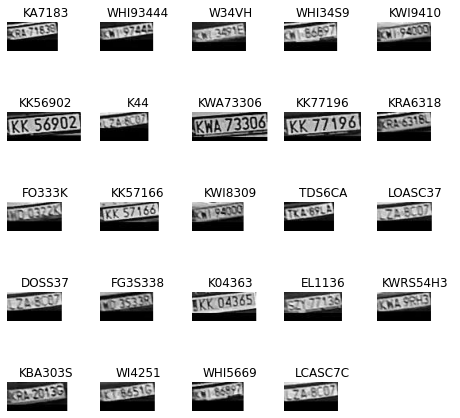

Character Accuracy: 53.00
Word Accuracy: 0.16


In [ ]:
args['imgdir'] = 'test'
args['data'] = SynthDataset(args)
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
if os.path.isfile(resume_file):
    print('Loading model %s'%resume_file)
    checkpoint = torch.load(resume_file)
#     model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False) # If mutli GPU
    args['model'] = model
    ca, wa = get_accuracy(args)
    print("Character Accuracy: %.2f\nWord Accuracy: %.2f"%(ca, wa))
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')